In [ ]:
# Extract the file IDs from the URLs
file_id_1 = "1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u"
file_id_2 = "1gesQepPirKYkd1i8cBMYaPOpyCxsDqJ-"

# Create a directory for the downloaded files
!mkdir -p downloaded_files

# Download the first file
!gdown --id {file_id_1} -O downloaded_files/file1.zip

# Download the second file
!gdown --id {file_id_2} -O downloaded_files/file2.zip

# Print the downloaded files to verify
!ls -la downloaded_files/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u
From (redirected): https://drive.google.com/uc?id=1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u&confirm=t&uuid=ce17a063-642f-43aa-8975-f3b8e5621ecf
To: /content/downloaded_files/file1.zip
100% 37.8M/37.8M [00:00<00:00, 99.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gesQepPirKYkd1i8cBMYaPOpyCxsDqJ-
To: /content/downloaded_files/file2.zip
100% 9.42M/9.42M [00:00<00:00, 30.5MB/s]
total 46164
drwxr-xr-x 2 root root     4096 Apr 19 02:27 .
drwxr-xr-x 1 root 

In [ ]:
# Unzip the first file
!unzip -o -q downloaded_files/file1 -d downloaded_files/file1_contents

# Unzip the second file
!unzip -o -q downloaded_files/file2 -d downloaded_files/file2_contents

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image processing
from PIL import Image
from skimage import transform, util, filters, color

# For splitting data
from sklearn.model_selection import train_test_split

# For evaluating results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Google colab patches
from google.colab.patches import cv2_imshow

## Prepro

In [ ]:
train_data_list = ['downloaded_files/file1_contents/train/' + i for i in os.listdir('downloaded_files/file1_contents/train')]
test_data_list = ['downloaded_files/file2_contents/test/' + i for i in os.listdir('downloaded_files/file2_contents/test')]

train_data_y = [i.replace('-0.png','') for i in os.listdir('downloaded_files/file1_contents/train')]
test_data_y = [i.replace('-0.png','') for i in os.listdir('downloaded_files/file2_contents/test')]

### func clean

In [ ]:
import cv2
import os
import numpy as np
from itertools import groupby
from operator import itemgetter
import imutils

def group_consecutive(indices, gap=1):
    groups = []
    start = indices[0]

    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > gap:
            end = indices[i - 1]
            groups.append((start, end))
            start = indices[i]

    # Add the final group
    groups.append((start, indices[-1]))
    return groups

def cut_images(file_path, save_path, labels_list, tolerance=4):
    try:
        # Load image
        image_raw = cv2.imread(file_path)
        image = remove_black_pixels_set_to_surrounding(image_raw)

        # Create the sharpening kernel
        kernel = np.array([[-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]])

        # Apply the sharpening kernel to the image using filter2D
        image = cv2.filter2D(image, -1, kernel)

        if image is None:
            raise ValueError(f"Could not load image from path: {file_path}")

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
        inverted = 255 - binary

        # Get projections
        projection_x = np.sum(inverted, axis=0)
        projection_y = np.sum(inverted, axis=1)

        # Thresholding projection to find regions of interest
        mean_x = np.mean(projection_x)
        mean_y = np.mean(projection_y)

        char_indices_x = np.where(projection_x > mean_x)[0]
        char_indices_y = np.where(projection_y > mean_y)[0]

        grouped_x = group_consecutive(char_indices_x)
        grouped_y = group_consecutive(char_indices_y)

        # Error check: labels must match number of x segments
        if len(grouped_x) != len(labels_list):
            raise ValueError(f"Label count ({len(labels_list)}) does not match detected character segments ({len(grouped_x)}).")

        # Make output folder
        os.makedirs(save_path, exist_ok=True)

        height, width = inverted.shape

        # Use only the first row group (assumes one line of characters)
        if len(grouped_y) == 0:
            raise ValueError("No horizontal text regions found.")
        y_start, y_end = grouped_y[0]

        for idx, (x_start, x_end) in enumerate(grouped_x):
            x0 = max(0, x_start - tolerance)
            x1 = min(width - 1, x_end + tolerance)
            y0 = max(0, y_start - tolerance)
            y1 = min(height - 1, y_end + tolerance)

            crop = inverted[y0:y1+1, x0:x1+1]
            label = labels_list[idx]
            filename = os.path.join(save_path, f"{label}.png")
            cv2.imwrite(filename, crop)
            # print(f"Saved: {filename}")

    except Exception as e:
        # print(f"[ERROR] {e}")
        return "ERROR"

def group_consecutive(indices, gap=1):
    groups = []
    start = indices[0]

    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > gap:
            end = indices[i - 1]
            groups.append((start, end))
            start = indices[i]

    # Add the final group
    groups.append((start, indices[-1]))
    return groups

def cut_images(file_path, save_path, labels_list, tolerance=4):
    """Cuts and saves regions of interest from an image."""
    try:
        image_raw = cv2.imread(file_path)
        image = remove_black_pixels_set_to_surrounding(image_raw)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)  # Use imutils to handle OpenCV version differences
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        if len(contours) != len(labels_list):
          raise ValueError('Inequal Length')

        for idx, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            roi = gray[y - tolerance : y + h + tolerance, x - tolerance : x + w + tolerance]
            filename = os.path.join(save_path, f"{labels_list[idx]}.png")
            cv2.imwrite(filename, roi)
        return None  # Indicate success

    except Exception as e:
        #print(f"[ERROR] {e}") #only print if debugging
        return "ERROR"
def remove_black_pixels(image):
  """
  Removes all black pixels (0, 0, 0) from an RGB image.

  Args:
    image: A NumPy array representing the RGB image (height, width, 3).

  Returns:
    A NumPy array representing the image with black pixels removed.
  """

  # Create a mask for non-black pixels
  mask = np.any(image != [0, 0, 0], axis=-1)

  # Apply the mask to the image
  result = image[mask]

  return result.reshape((-1, 3)) #reshape to a list of RGB pixels

def remove_black_pixels_white(image):
    """
    Removes all black pixels (0, 0, 0) from an RGB image and returns an image with the same shape, where black pixels are replaced with white.
    Args:
        image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
        A NumPy array representing the image with black pixels replaced with nan.
    """
    mask = np.all(image == [0, 0, 0], axis=-1)
    result = image.astype(int)
    result[mask] = [255, 255, 255]
    return result

def remove_black_pixels_set_to_surrounding(image):
    """
    Removes all black pixels (0, 0, 0) from an RGB image and replaces them with colors from surrounding pixels.

    Args:
      image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
      A NumPy array representing the image with black pixels inpainted with surrounding colors.
    """
    # Create a binary mask where black pixels are 0 and non-black pixels are 1
    mask = np.all(image == [0, 0, 0], axis=-1).astype(np.uint8)

    # Invert the mask for inpainting (inpainting occurs where mask is non-zero)
    inpaint_mask = mask * 255

    # Use OpenCV's inpainting function to fill black pixels with surrounding colors
    # INPAINT_TELEA is an algorithm that considers neighboring pixels to fill in the masked region
    result = cv2.inpaint(image, inpaint_mask, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

    return result

# Alternative approach using Gaussian blur for smaller black regions
def remove_black_pixels_with_blur(image):
    """
    Removes small black regions by replacing them with blurred surrounding colors.
    Works best for scattered individual black pixels.

    Args:
      image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
      A NumPy array representing the image with black pixels replaced.
    """
    # Create a copy of the image
    result = image.copy()

    # Create a mask of black pixels
    mask = np.all(image == [0, 0, 0], axis=-1)

    # Create a blurred version of the image
    blurred = cv2.GaussianBlur(image, (15, 15), 0)

    # Replace black pixels with their corresponding pixels from the blurred image
    result[mask] = blurred[mask]

    return result

In [ ]:
def split_image_v(image, k):
  """
  Splits a 3-channel (e.g., RGB) image vertically into k pieces, rounding the slice width.

  Args:
    image: A numpy array representing the image, with shape (height, width, 3).
    k: The number of pieces to split the image into.

  Returns:
    A list of numpy arrays, each representing a vertical slice of the image.
    If k is not a positive integer, or width is less than k returns an empty list.
  """

  if not isinstance(k, int) or k <= 0 or image.shape[1] < k:
    return []  # Invalid k or width too small, return empty list

  height, width, channels = image.shape
  slice_width = round(width / k)  # Round the slice width

  slices = []
  start_x = 0
  for i in range(k):
    end_x = min(start_x + slice_width, width)  # Ensure we don't exceed image bounds
    slices.append(image[:, start_x:end_x, :])
    start_x = end_x

  return slices

In [ ]:
from collections import Counter

def get_top_k_colors(img, k=5):
    """
    Gets the top k most frequent colors in an image using OpenCV.

    Args:
        image_path (str): Path to the image file.
        k (int): Number of top colors to retrieve.

    Returns:
        list: A list of tuples, where each tuple is (color, count), sorted by count
              in descending order. Returns None if an error occurs.
    """
    try:
        pixels = img.reshape((-1, 3))
        pixel_tuples = [tuple(pixel) for pixel in pixels]  # Convert to tuples for Counter

        color_counts = Counter(pixel_tuples)
        top_k_colors = color_counts.most_common(k)

        return top_k_colors

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
def filt_top(top_k):
  last = 0
  cur = 0
  fin_list = []
  # top_16 = get_top_k_colors(image_no_lines, 16)
  for i in range(14):
    try:
      c1, ct_1 = top_k[i][0], top_k[i][1]
      c2, ct_2 = top_k[i+1][0], top_k[i+1][1]
      c3, ct_3 = top_k[i+2][0], top_k[i+2][1]

      not_allowed = [(0,0,0), (254, 254, 254), (255, 255, 255), (255, 254, 254),(254,255,255), (255,254,255), (255,255,254)]

      if c1 in not_allowed:
        continue
      else:
        if ct_1 / 2 < ct_2:
          fin_list.append(c1)
        elif ct_1 / 2 > ct_2 and ct_2 / 2 > ct_3:
          fin_list.append(c1)
        else:
          fin_list.append(c1)
          break
    except IndexError:
      continue

  return len(fin_list)

In [ ]:
def stack_images_horizontally(images, spacing=10, color=(128, 128, 128)):
    # Resize images to the same height
    heights = [img.shape[0] for img in images]
    min_height = min(heights)
    resized_images = [
        cv2.resize(img, (int(img.shape[1] * min_height / img.shape[0]), min_height))
        for img in images
    ]

    # Create spacer image
    spacer_width = spacing
    spacer_height = min_height
    spacer = np.full((spacer_height, spacer_width, 3), color, dtype=np.uint8)

    # Stack images with spacers
    stacked = resized_images[0]
    for img in resized_images[1:]:
        stacked = np.hstack((stacked, spacer, img))
    cv2_imshow(stacked)
    # return stacked


### clear noise

uqco


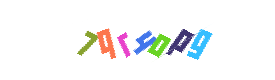

In [ ]:
random_idx = np.random.choice(8000)
print(train_data_y[random_idx])
image = cv2.imread(train_data_list[random_idx])

image = cv2.imread('/content/downloaded_files/file1_contents/train/7qr4opg-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/j18w-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/l1hjnwj-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/480c-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/ykjhkmhc-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/7p6te6h-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/cjzjeas-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/rtphiefz-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/r3w8w7m-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/o1ou-0.png')
image_no_lines = remove_black_pixels_set_to_surrounding(image)

# Create the sharpening kernel
# kernel = np.array([[0, -1, 0], [-1, 4.4, -1], [0, -1, 0]])
# Sharpen the image
# image_no_lines = cv2.filter2D(image_no_lines, -1, kernel)

# image_no_lines = cv2.convertScaleAbs(image_no_lines, alpha=1, beta=1)

# image_no_lines = cv2.resize(image_no_lines, (560, 70), interpolation = cv2.INTER_AREA)

cv2_imshow(image_no_lines)
# cv2_imshow(image)

# cutted = separate_pic(image_no_lines)
# print (len(cutted))

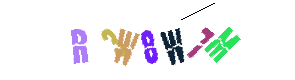

In [ ]:
cv2_imshow(image)

In [ ]:
def filter_overlapping_tuples(tuples_list):
    """
    Filter out tuples that overlap with at least 90% with larger tuples.

    Args:
        tuples_list: List of tuples in the form (a, b) where a < b and both are integers

    Returns:
        List of tuples after filtering out those with 90% or more overlap with larger tuples
    """
    if not tuples_list:
        return []

    # Sort tuples by size (b-a) in descending order
    sorted_tuples = sorted(tuples_list, key=lambda t: t[1] - t[0], reverse=True)

    result = []

    for i, (a1, b1) in enumerate(sorted_tuples):
        should_keep = True
        size1 = b1 - a1

        for j, (a2, b2) in enumerate(result):
            size2 = b2 - a2

            # Calculate overlap
            overlap_start = max(a1, a2)
            overlap_end = min(b1, b2)

            if overlap_start < overlap_end:  # There is an overlap
                overlap_size = overlap_end - overlap_start

                # Calculate overlap percentage relative to the current tuple
                overlap_percentage = overlap_size / size1

                if overlap_percentage >= 0.8:  # 90% or more overlap
                    should_keep = False
                    break

        if should_keep:
            result.append((a1, b1))

    return result

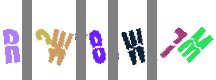

In [ ]:
stack_images_horizontally(x)

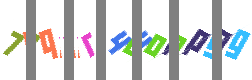

In [ ]:
x = separate_line_white(image_no_lines)
xv = np.hstack(x)
xvs = separate_pic(xv)
# stack_images_horizontally(xvs)

if len(x) > len(xvs) and len(x) < 9:
  fin = x
else:
  fin = xvs

stack_images_horizontally(fin)


138 550
<class 'numpy.ndarray'>
1


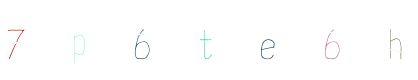

In [ ]:
cutted = separate_pic(image_no_lines)
print (len(cutted))
stack_images_horizontally(cutted)
# cv2_imshow(cutted[0])

In [ ]:
get_top_k_colors(separate_line_white(image_no_lines)[3], k=10)

[((np.uint8(255), np.uint8(255), np.uint8(255)), 4813),
 ((np.uint8(68), np.uint8(164), np.uint8(136)), 398),
 ((np.uint8(42), np.uint8(148), np.uint8(200)), 277),
 ((np.uint8(254), np.uint8(255), np.uint8(255)), 12),
 ((np.uint8(253), np.uint8(254), np.uint8(255)), 5),
 ((np.uint8(76), np.uint8(168), np.uint8(141)), 5),
 ((np.uint8(46), np.uint8(150), np.uint8(201)), 5),
 ((np.uint8(124), np.uint8(189), np.uint8(221)), 4),
 ((np.uint8(216), np.uint8(236), np.uint8(230)), 4),
 ((np.uint8(72), np.uint8(166), np.uint8(139)), 4)]

In [ ]:
def convert_lists_to_tuples(lists):
    """
    Convert lists of consecutive integers to (min, max) tuples

    Args:
        lists: List of lists, where each inner list contains consecutive integers

    Returns:
        List of tuples (min, max) representing the ranges
    """
    tuples = []
    for lst in lists:
        if lst:  # Ensure list is not empty
            tuples.append((min(lst), max(lst)))
    return tuples

def filter_overlapping_tuples(tuples_list):
    """
    Filter out tuples that overlap with at least 90% with larger tuples.

    Args:
        tuples_list: List of tuples in the form (a, b) where a < b and both are integers

    Returns:
        List of tuples after filtering out those with 90% or more overlap with larger tuples
    """
    if not tuples_list:
        return []

    # Sort tuples by size (b-a) in descending order
    sorted_tuples = sorted(tuples_list, key=lambda t: t[1] - t[0], reverse=True)

    result = []

    for i, (a1, b1) in enumerate(sorted_tuples):
        should_keep = True
        size1 = b1 - a1

        for j, (a2, b2) in enumerate(result):
            size2 = b2 - a2

            # Calculate overlap
            overlap_start = max(a1, a2)
            overlap_end = min(b1, b2)

            if overlap_start <= overlap_end:  # There is an overlap
                overlap_size = overlap_end - overlap_start + 1  # +1 because ranges are inclusive

                # Calculate overlap percentage relative to the current tuple
                overlap_percentage = overlap_size / (size1 + 1)  # +1 because ranges are inclusive

                if overlap_percentage >= 0.9:  # 90% or more overlap
                    should_keep = False
                    break

        if should_keep:
            result.append((a1, b1))

    return result

def process_input_lists(lists):
    """
    Process lists of consecutive integers, convert to tuples, filter overlapping ones,
    and return the filtered tuples.

    Args:
        lists: List of lists, where each inner list contains consecutive integers

    Returns:
        List of tuples after filtering out those with significant overlap
    """
    tuples = convert_lists_to_tuples(lists)
    filtered_tuples = filter_overlapping_tuples(tuples)
    return filtered_tuples

def convert_tuples_to_lists(tuples):
    """
    Convert tuples back to lists of consecutive integers

    Args:
        tuples: List of tuples (min, max) representing ranges

    Returns:
        List of lists, where each inner list contains all integers in the range
    """
    result = []
    for a, b in tuples:
        result.append(list(range(a, b + 1)))  # +1 to include the end value
    return result

In [ ]:
def separate_line_white(image_input):
  important = None  # Initialize a variable to store important image data
  important_idx = []  # Initialize a list to store indices of important columns
  height = image_input.shape[1]  # Get the height of the image (though this looks like width based on usage)
  image_avg = image_input.mean(axis=2)  # Calculate average across color channels (converting to grayscale)

  # Iterate through each column of the image
  for i in range(image_input.shape[1]):
      l = image_avg[:, i]  # Get the grayscale values for column i
      l_mean = l.mean()  # Calculate the mean value of the column
      if l_mean <= 254:  # If the mean value is not completely white (allowing for small deviations)
          important_idx.append(i)  # Add this column index to important indices
          if important is not None:
              important = np.vstack([important, l])  # Add column to existing important data
          else:
              important = l  # Initialize important data with this column

  # Group consecutive column indices to identify continuous regions
  groups = group_consecutive(important_idx)
  group_ct = len(groups)  # Count how many separate groups/regions exist
  # print(group_ct)  # Print the number of regions

  clean = list()  # Initialize a list to store processed image regions
  for a, b in groups:
    clean.append(image_input[:, a-3:b+3])
  return clean

def separate_pic(image_input):
  clean = list()  # Initialize a list to store processed image regions

  # Determine how many top colors to analyze
  suspect_amt = filt_top(get_top_k_colors(image_input, 11))
  # print(suspect_amt)  # Print the number of colors to analyze

  color_column_indices_list = []  # Initialize a list to store column indices for each color

  # For each prominent color in the image
  for color_data in get_top_k_colors(image_input, suspect_amt + 1):
      rgb_val = color_data[0]  # Get the RGB value of the color
      if rgb_val == (255, 255, 255):
          continue  # Skip white pixels as they're not informative

      column_indices = []  # Initialize a list to store columns containing this color

      # Check each column for the presence of this color
      for col_idx in range(image_input.shape[1]):
          column = image_input[:, col_idx]  # Extract the column
          for pixel in column:
              if tuple(pixel) == rgb_val:  # Compare the pixel's RGB value to the target color
                  column_indices.append(col_idx)  # If found, record this column
                  break  # Once found in a column, no need to check more pixels in same column

      color_column_indices_list.append(column_indices)  # Add the list of columns for this color

  filtered_tuples = process_input_lists(color_column_indices_list)
  color_column_indices_list = convert_tuples_to_lists(filtered_tuples)

  # Find the leftmost position (minimum index) for each color
  min_list = np.array([])
  for k in color_column_indices_list:
      a = np.min(k)  # Find leftmost position of this color
      b = np.max(k)  # Find rightmost position of this color (not used here)
      min_list = np.append(min_list, a)  # Add the minimum position to our list

  # Sort the colors by their leftmost appearance in the image
  list_of_order = min_list[np.argsort(min_list)]

  # Initialize a list to store image regions, one per color
  clean = [0] * len(color_column_indices_list)

  # Extract image regions for each color based on their sorted order
  for k in color_column_indices_list:
      a = np.min(k)   # Leftmost column for this color
      b = np.max(k)  # Rightmost column for this color
      # print (a, b)
      idx = np.where(list_of_order == a)[0][0]  # Find the position of this color in the sorted order
      # print (type(image_input))
      clean[idx] = image_input[:, max(0, a - 3):min(image_input.shape[1],b + 3)]  # Extract the image region spanning from leftmost to rightmost

  return clean

In [ ]:
def whole_prepro(img_path, save_path, saver=False):
  image = cv2.imread(img_path)
  # cv2_imshow(image)
  image_no_lines = remove_black_pixels_set_to_surrounding(image)
  x = separate_line_white(image_no_lines)
  xv = np.hstack(x)
  xvs = separate_pic(xv)

  if len(x) > len(xvs) and len(x) < 9:
    fin = x
  else:
    fin = xvs

  namestr = img_path.split('/')[-1].replace('-0.png','')

  if saver:
    for i, (pic, name) in enumerate(zip(fin, namestr)):
      try:
        cv2.imwrite(os.path.join(save_path, f"pic_{namestr}_{i}_{name}.png"), pic)
      except Exception as e:
        continue
  else:
    pass

  return fin

### rule-based cut

In [ ]:
import shutil

shutil.rmtree('train_crops')

In [ ]:
import os
from tqdm import tqdm

def process_images_with_tqdm(train_data_list, train_data_y, save_path_train, tolerance=4):
    """Processes images using cut_images and displays progress with tqdm."""

    errors = 0
    for file_path, file_name in tqdm(zip(train_data_list, train_data_y), total=len(train_data_list), desc="Processing images"):
        list_of_label = list(file_name)
        if len(list_of_label) != len(whole_prepro(file_path, save_path_train)):
          errors += 1
          print(errors)
        else:
          whole_prepro(file_path, save_path_train, saver=True)

    return errors

save_path_train = "train_crops"

# Ensure the output directory exists
os.makedirs(save_path_train, exist_ok=True)

errors_count = process_images_with_tqdm(train_data_list, train_data_y, save_path_train)

print(f"Total errors: {errors_count}")

Processing images:   0%|          | 16/8010 [00:04<24:12,  5.50it/s]

1


Processing images:   0%|          | 24/8010 [00:05<26:11,  5.08it/s]

2


Processing images:   1%|          | 51/8010 [00:14<54:16,  2.44it/s]

3


Processing images:   1%|          | 64/8010 [00:18<30:16,  4.37it/s]

4


Processing images:   1%|          | 72/8010 [00:20<24:53,  5.32it/s]

5


Processing images:   1%|          | 73/8010 [00:20<23:47,  5.56it/s]

6


Processing images:   1%|          | 85/8010 [00:23<28:53,  4.57it/s]

7


Processing images:   1%|          | 94/8010 [00:26<46:10,  2.86it/s]

8


Processing images:   1%|▏         | 105/8010 [00:29<27:07,  4.86it/s]

9


Processing images:   1%|▏         | 118/8010 [00:32<29:15,  4.50it/s]

10


Processing images:   2%|▏         | 126/8010 [00:35<29:53,  4.40it/s]

11


Processing images:   2%|▏         | 140/8010 [00:40<37:12,  3.52it/s]

12


Processing images:   2%|▏         | 153/8010 [00:44<30:01,  4.36it/s]

13


Processing images:   2%|▏         | 155/8010 [00:44<34:10,  3.83it/s]

14


Processing images:   2%|▏         | 164/8010 [00:47<32:32,  4.02it/s]

15


Processing images:   2%|▏         | 169/8010 [00:48<25:18,  5.16it/s]

16


Processing images:   2%|▏         | 188/8010 [00:55<34:13,  3.81it/s]

17
18


Processing images:   2%|▏         | 191/8010 [00:55<27:59,  4.66it/s]

19


Processing images:   3%|▎         | 205/8010 [00:59<26:31,  4.90it/s]

20


Processing images:   3%|▎         | 223/8010 [01:05<43:19,  3.00it/s]

21


Processing images:   3%|▎         | 235/8010 [01:09<35:51,  3.61it/s]

22


Processing images:   3%|▎         | 236/8010 [01:09<36:21,  3.56it/s]

23


Processing images:   3%|▎         | 274/8010 [01:20<41:02,  3.14it/s]

24


Processing images:   3%|▎         | 278/8010 [01:21<29:57,  4.30it/s]

25


Processing images:   4%|▎         | 283/8010 [01:23<41:21,  3.11it/s]

26


Processing images:   4%|▎         | 292/8010 [01:25<30:00,  4.29it/s]

27


Processing images:   4%|▍         | 309/8010 [01:31<36:08,  3.55it/s]

28


Processing images:   4%|▍         | 317/8010 [01:33<28:58,  4.42it/s]

29


Processing images:   4%|▍         | 347/8010 [01:44<51:16,  2.49it/s]

30


Processing images:   5%|▍         | 375/8010 [01:52<40:01,  3.18it/s]

31


Processing images:   5%|▍         | 382/8010 [01:55<34:33,  3.68it/s]

32


Processing images:   5%|▌         | 404/8010 [02:00<25:15,  5.02it/s]

33


Processing images:   5%|▌         | 408/8010 [02:01<17:55,  7.07it/s]

34
35


Processing images:   5%|▌         | 414/8010 [02:02<31:56,  3.96it/s]

36


Processing images:   5%|▌         | 417/8010 [02:03<25:26,  4.97it/s]

37


Processing images:   5%|▌         | 419/8010 [02:03<23:16,  5.43it/s]

38


Processing images:   5%|▌         | 422/8010 [02:04<22:05,  5.72it/s]

39


Processing images:   6%|▌         | 456/8010 [02:15<30:57,  4.07it/s]

40


Processing images:   6%|▌         | 458/8010 [02:15<27:43,  4.54it/s]

41


Processing images:   6%|▌         | 474/8010 [02:21<27:43,  4.53it/s]

42


Processing images:   6%|▌         | 475/8010 [02:21<47:41,  2.63it/s]

43


Processing images:   6%|▌         | 487/8010 [02:25<44:42,  2.80it/s]

44


Processing images:   6%|▌         | 491/8010 [02:26<32:10,  3.89it/s]

45


Processing images:   6%|▋         | 502/8010 [02:29<27:16,  4.59it/s]

46
47


Processing images:   6%|▋         | 507/8010 [02:31<45:28,  2.75it/s]

48


Processing images:   6%|▋         | 512/8010 [02:32<29:06,  4.29it/s]

49


Processing images:   7%|▋         | 532/8010 [02:38<26:10,  4.76it/s]

50


Processing images:   7%|▋         | 550/8010 [02:44<55:29,  2.24it/s]  

51


Processing images:   7%|▋         | 551/8010 [02:44<47:09,  2.64it/s]

52


Processing images:   7%|▋         | 570/8010 [02:50<23:49,  5.21it/s]

53


Processing images:   7%|▋         | 585/8010 [02:54<29:51,  4.14it/s]

54


Processing images:   7%|▋         | 590/8010 [02:56<36:53,  3.35it/s]

55
56


Processing images:   8%|▊         | 603/8010 [03:00<28:19,  4.36it/s]

57


Processing images:   8%|▊         | 608/8010 [03:01<31:59,  3.86it/s]

58


Processing images:   8%|▊         | 625/8010 [03:06<1:03:19,  1.94it/s]

59


Processing images:   8%|▊         | 631/8010 [03:08<47:49,  2.57it/s]

60


Processing images:   8%|▊         | 635/8010 [03:10<40:41,  3.02it/s]

61


Processing images:   8%|▊         | 651/8010 [03:15<28:09,  4.35it/s]

62


Processing images:   8%|▊         | 659/8010 [03:18<53:32,  2.29it/s]

63


Processing images:   8%|▊         | 663/8010 [03:18<28:57,  4.23it/s]

64
65


Processing images:   8%|▊         | 668/8010 [03:20<32:21,  3.78it/s]

66


Processing images:   9%|▊         | 688/8010 [03:27<49:02,  2.49it/s]

67


Processing images:   9%|▊         | 693/8010 [03:29<38:07,  3.20it/s]

68


Processing images:   9%|▉         | 703/8010 [03:31<24:08,  5.05it/s]

69


Processing images:   9%|▉         | 709/8010 [03:33<43:25,  2.80it/s]

70


Processing images:   9%|▉         | 718/8010 [03:37<43:59,  2.76it/s]

71


Processing images:   9%|▉         | 736/8010 [03:41<17:11,  7.05it/s]

72
73


Processing images:   9%|▉         | 742/8010 [03:42<23:38,  5.12it/s]

74


Processing images:   9%|▉         | 744/8010 [03:42<21:18,  5.69it/s]

75


Processing images:  10%|▉         | 785/8010 [03:54<26:42,  4.51it/s]

76


Processing images:  10%|█         | 805/8010 [04:01<38:25,  3.13it/s]

77


Processing images:  10%|█         | 806/8010 [04:01<31:56,  3.76it/s]

78


Processing images:  10%|█         | 818/8010 [04:05<25:50,  4.64it/s]

79


Processing images:  10%|█         | 819/8010 [04:05<24:45,  4.84it/s]

80


Processing images:  10%|█         | 831/8010 [04:09<40:03,  2.99it/s]

81


Processing images:  10%|█         | 834/8010 [04:09<29:22,  4.07it/s]

82


Processing images:  11%|█         | 848/8010 [04:14<26:45,  4.46it/s]

83


Processing images:  11%|█         | 865/8010 [04:19<28:27,  4.18it/s]

84


Processing images:  11%|█         | 875/8010 [04:22<27:16,  4.36it/s]

85


Processing images:  11%|█         | 880/8010 [04:24<56:12,  2.11it/s]

86


Processing images:  11%|█         | 881/8010 [04:25<49:59,  2.38it/s]

87


Processing images:  11%|█         | 887/8010 [04:27<32:02,  3.70it/s]

88


Processing images:  11%|█▏        | 902/8010 [04:32<43:44,  2.71it/s]

89


Processing images:  11%|█▏        | 915/8010 [04:35<29:40,  3.98it/s]

90


Processing images:  12%|█▏        | 926/8010 [04:40<35:54,  3.29it/s]

91


Processing images:  12%|█▏        | 929/8010 [04:40<26:23,  4.47it/s]

92
93


Processing images:  12%|█▏        | 938/8010 [04:42<23:32,  5.01it/s]

94


Processing images:  12%|█▏        | 944/8010 [04:44<26:42,  4.41it/s]

95


Processing images:  12%|█▏        | 950/8010 [04:45<17:15,  6.82it/s]

96
97


Processing images:  12%|█▏        | 965/8010 [04:52<58:43,  2.00it/s]  

98


Processing images:  12%|█▏        | 979/8010 [04:56<28:59,  4.04it/s]

99


Processing images:  12%|█▏        | 986/8010 [04:58<24:53,  4.70it/s]

100


Processing images:  12%|█▏        | 992/8010 [05:00<37:03,  3.16it/s]

101


Processing images:  12%|█▏        | 998/8010 [05:03<42:02,  2.78it/s]

102


Processing images:  13%|█▎        | 1015/8010 [05:08<27:09,  4.29it/s]

103


Processing images:  13%|█▎        | 1018/8010 [05:09<27:32,  4.23it/s]

104


Processing images:  13%|█▎        | 1022/8010 [05:11<36:24,  3.20it/s]

105


Processing images:  13%|█▎        | 1037/8010 [05:14<22:38,  5.13it/s]

106


Processing images:  13%|█▎        | 1038/8010 [05:14<27:30,  4.22it/s]

107


Processing images:  13%|█▎        | 1041/8010 [05:15<24:53,  4.66it/s]

108


Processing images:  13%|█▎        | 1052/8010 [05:19<29:52,  3.88it/s]

109


Processing images:  13%|█▎        | 1056/8010 [05:20<39:32,  2.93it/s]

110


Processing images:  13%|█▎        | 1061/8010 [05:22<34:09,  3.39it/s]

111


Processing images:  14%|█▎        | 1091/8010 [05:31<54:23,  2.12it/s]

112


Processing images:  14%|█▍        | 1137/8010 [05:46<31:21,  3.65it/s]

113


Processing images:  14%|█▍        | 1144/8010 [05:47<26:07,  4.38it/s]

114


Processing images:  14%|█▍        | 1147/8010 [05:48<23:16,  4.91it/s]

115


Processing images:  14%|█▍        | 1149/8010 [05:49<41:13,  2.77it/s]

116


Processing images:  14%|█▍        | 1160/8010 [05:53<40:34,  2.81it/s]

117


Processing images:  15%|█▍        | 1172/8010 [05:57<32:34,  3.50it/s]

118


Processing images:  15%|█▍        | 1181/8010 [06:01<37:09,  3.06it/s]

119


Processing images:  15%|█▍        | 1197/8010 [06:07<52:15,  2.17it/s]

120


Processing images:  15%|█▍        | 1199/8010 [06:08<48:25,  2.34it/s]  

121


Processing images:  15%|█▌        | 1202/8010 [06:08<34:15,  3.31it/s]

122


Processing images:  15%|█▌        | 1205/8010 [06:09<27:52,  4.07it/s]

123


Processing images:  15%|█▌        | 1207/8010 [06:10<22:14,  5.10it/s]

124


Processing images:  15%|█▌        | 1213/8010 [06:12<37:50,  2.99it/s]

125


Processing images:  15%|█▌        | 1223/8010 [06:14<20:47,  5.44it/s]

126


Processing images:  15%|█▌        | 1226/8010 [06:14<17:08,  6.60it/s]

127
128


Processing images:  15%|█▌        | 1237/8010 [06:18<29:29,  3.83it/s]

129


Processing images:  16%|█▌        | 1242/8010 [06:20<40:32,  2.78it/s]

130


Processing images:  16%|█▌        | 1250/8010 [06:23<32:09,  3.50it/s]

131


Processing images:  16%|█▌        | 1285/8010 [06:34<38:12,  2.93it/s]

132


Processing images:  16%|█▌        | 1292/8010 [06:36<26:54,  4.16it/s]

133
134


Processing images:  16%|█▌        | 1294/8010 [06:37<22:25,  4.99it/s]

135


Processing images:  16%|█▋        | 1314/8010 [06:42<31:18,  3.56it/s]

136


Processing images:  17%|█▋        | 1329/8010 [06:48<30:09,  3.69it/s]

137


Processing images:  17%|█▋        | 1334/8010 [06:50<23:35,  4.72it/s]

138


Processing images:  17%|█▋        | 1337/8010 [06:50<17:42,  6.28it/s]

139
140


Processing images:  17%|█▋        | 1342/8010 [06:51<24:44,  4.49it/s]

141


Processing images:  17%|█▋        | 1344/8010 [06:52<24:28,  4.54it/s]

142


Processing images:  17%|█▋        | 1348/8010 [06:54<37:17,  2.98it/s]

143


Processing images:  17%|█▋        | 1393/8010 [07:09<24:51,  4.44it/s]

144


Processing images:  17%|█▋        | 1394/8010 [07:10<25:58,  4.25it/s]

145


Processing images:  18%|█▊        | 1418/8010 [07:18<23:12,  4.73it/s]

146


Processing images:  18%|█▊        | 1432/8010 [07:21<26:13,  4.18it/s]

147


Processing images:  18%|█▊        | 1436/8010 [07:22<24:36,  4.45it/s]

148


Processing images:  18%|█▊        | 1442/8010 [07:24<29:39,  3.69it/s]

149


Processing images:  18%|█▊        | 1454/8010 [07:29<25:54,  4.22it/s]

150
151


Processing images:  18%|█▊        | 1457/8010 [07:30<26:11,  4.17it/s]

152


Processing images:  19%|█▊        | 1482/8010 [07:38<27:03,  4.02it/s]

153


Processing images:  19%|█▊        | 1492/8010 [07:41<28:44,  3.78it/s]

154


Processing images:  19%|█▊        | 1493/8010 [07:42<34:29,  3.15it/s]

155


Processing images:  19%|█▊        | 1497/8010 [07:43<24:37,  4.41it/s]

156


Processing images:  19%|█▉        | 1519/8010 [07:49<23:29,  4.60it/s]

157
158


Processing images:  19%|█▉        | 1525/8010 [07:51<35:04,  3.08it/s]

159


Processing images:  19%|█▉        | 1527/8010 [07:51<31:57,  3.38it/s]

160


Processing images:  19%|█▉        | 1531/8010 [07:53<31:55,  3.38it/s]

161


Processing images:  19%|█▉        | 1535/8010 [07:54<27:53,  3.87it/s]

162


Processing images:  19%|█▉        | 1552/8010 [07:59<21:33,  4.99it/s]

163


Processing images:  19%|█▉        | 1557/8010 [08:01<31:33,  3.41it/s]

164


Processing images:  19%|█▉        | 1560/8010 [08:01<19:52,  5.41it/s]

165


Processing images:  20%|█▉        | 1576/8010 [08:09<37:32,  2.86it/s]

166


Processing images:  20%|█▉        | 1581/8010 [08:10<23:54,  4.48it/s]

167


Processing images:  20%|█▉        | 1587/8010 [08:12<36:14,  2.95it/s]

168


Processing images:  20%|█▉        | 1594/8010 [08:15<36:18,  2.95it/s]

169


Processing images:  20%|██        | 1609/8010 [08:21<30:49,  3.46it/s]

170


Processing images:  20%|██        | 1617/8010 [08:24<27:04,  3.94it/s]

171


Processing images:  20%|██        | 1629/8010 [08:28<27:13,  3.91it/s]

172


Processing images:  20%|██        | 1639/8010 [08:31<24:38,  4.31it/s]

173
174


Processing images:  21%|██        | 1649/8010 [08:34<25:26,  4.17it/s]

175


Processing images:  21%|██        | 1652/8010 [08:34<24:25,  4.34it/s]

176


Processing images:  21%|██        | 1658/8010 [08:37<39:03,  2.71it/s]

177


Processing images:  21%|██        | 1661/8010 [08:37<33:34,  3.15it/s]

178


Processing images:  21%|██        | 1679/8010 [08:43<30:29,  3.46it/s]

179


Processing images:  21%|██        | 1690/8010 [08:46<28:24,  3.71it/s]

180


Processing images:  21%|██        | 1701/8010 [08:49<19:12,  5.48it/s]

181


Processing images:  21%|██▏       | 1707/8010 [08:51<33:09,  3.17it/s]

182


Processing images:  21%|██▏       | 1713/8010 [08:52<20:24,  5.14it/s]

183


Processing images:  21%|██▏       | 1719/8010 [08:54<22:16,  4.71it/s]

184


Processing images:  22%|██▏       | 1726/8010 [08:56<33:53,  3.09it/s]

185


Processing images:  22%|██▏       | 1734/8010 [09:00<31:22,  3.33it/s]

186


Processing images:  22%|██▏       | 1736/8010 [09:00<26:25,  3.96it/s]

187


Processing images:  22%|██▏       | 1740/8010 [09:01<22:22,  4.67it/s]

188


Processing images:  22%|██▏       | 1752/8010 [09:04<21:38,  4.82it/s]

189


Processing images:  22%|██▏       | 1756/8010 [09:05<19:36,  5.31it/s]

190


Processing images:  22%|██▏       | 1764/8010 [09:08<30:31,  3.41it/s]

191


Processing images:  22%|██▏       | 1771/8010 [09:11<39:42,  2.62it/s]

192


Processing images:  22%|██▏       | 1774/8010 [09:12<39:28,  2.63it/s]

193


Processing images:  22%|██▏       | 1782/8010 [09:14<18:54,  5.49it/s]

194


Processing images:  23%|██▎       | 1807/8010 [09:21<18:16,  5.66it/s]

195


Processing images:  23%|██▎       | 1813/8010 [09:23<30:49,  3.35it/s]

196


Processing images:  23%|██▎       | 1820/8010 [09:25<28:08,  3.66it/s]

197


Processing images:  23%|██▎       | 1822/8010 [09:26<22:38,  4.55it/s]

198


Processing images:  23%|██▎       | 1826/8010 [09:27<27:14,  3.78it/s]

199
200


Processing images:  23%|██▎       | 1827/8010 [09:27<26:31,  3.89it/s]

201


Processing images:  23%|██▎       | 1864/8010 [09:40<36:51,  2.78it/s]

202


Processing images:  23%|██▎       | 1876/8010 [09:43<18:07,  5.64it/s]

203


Processing images:  24%|██▎       | 1887/8010 [09:47<36:37,  2.79it/s]

204


Processing images:  24%|██▎       | 1893/8010 [09:48<29:23,  3.47it/s]

205


Processing images:  24%|██▎       | 1902/8010 [09:52<31:39,  3.22it/s]

206
207


Processing images:  24%|██▍       | 1928/8010 [10:01<39:06,  2.59it/s]

208


Processing images:  24%|██▍       | 1931/8010 [10:01<23:25,  4.32it/s]

209


Processing images:  24%|██▍       | 1955/8010 [10:11<35:01,  2.88it/s]

210


Processing images:  25%|██▍       | 1964/8010 [10:14<20:49,  4.84it/s]

211


Processing images:  25%|██▍       | 1973/8010 [10:17<25:04,  4.01it/s]

212
213


Processing images:  25%|██▍       | 1988/8010 [10:21<19:48,  5.07it/s]

214


Processing images:  25%|██▍       | 1995/8010 [10:23<20:14,  4.95it/s]

215


Processing images:  25%|██▍       | 2002/8010 [10:25<29:46,  3.36it/s]

216


Processing images:  25%|██▌       | 2031/8010 [10:36<33:44,  2.95it/s]

217


Processing images:  25%|██▌       | 2033/8010 [10:37<27:53,  3.57it/s]

218


Processing images:  26%|██▌       | 2077/8010 [10:51<15:22,  6.43it/s]

219


Processing images:  26%|██▌       | 2080/8010 [10:52<21:52,  4.52it/s]

220


Processing images:  26%|██▌       | 2090/8010 [10:56<45:50,  2.15it/s]

221


Processing images:  26%|██▋       | 2105/8010 [11:01<31:12,  3.15it/s]

222


Processing images:  27%|██▋       | 2148/8010 [11:16<22:44,  4.29it/s]

223


Processing images:  27%|██▋       | 2171/8010 [11:24<22:18,  4.36it/s]

224


Processing images:  27%|██▋       | 2180/8010 [11:28<39:30,  2.46it/s]

225


Processing images:  27%|██▋       | 2187/8010 [11:30<30:41,  3.16it/s]

226


Processing images:  27%|██▋       | 2194/8010 [11:32<25:00,  3.88it/s]

227


Processing images:  27%|██▋       | 2196/8010 [11:32<19:34,  4.95it/s]

228


Processing images:  27%|██▋       | 2200/8010 [11:33<34:02,  2.84it/s]

229


Processing images:  27%|██▋       | 2202/8010 [11:34<27:05,  3.57it/s]

230


Processing images:  28%|██▊       | 2214/8010 [11:38<33:09,  2.91it/s]

231


Processing images:  28%|██▊       | 2220/8010 [11:40<25:50,  3.73it/s]

232


Processing images:  28%|██▊       | 2231/8010 [11:43<22:22,  4.30it/s]

233


Processing images:  28%|██▊       | 2245/8010 [11:50<50:47,  1.89it/s]  

234


Processing images:  28%|██▊       | 2250/8010 [11:51<27:25,  3.50it/s]

235


Processing images:  28%|██▊       | 2251/8010 [11:52<24:40,  3.89it/s]

236


Processing images:  28%|██▊       | 2256/8010 [11:53<22:54,  4.19it/s]

237


Processing images:  28%|██▊       | 2275/8010 [11:58<26:28,  3.61it/s]

238


Processing images:  28%|██▊       | 2281/8010 [12:00<25:05,  3.81it/s]

239


Processing images:  29%|██▊       | 2286/8010 [12:02<36:38,  2.60it/s]

240


Processing images:  29%|██▊       | 2296/8010 [12:05<21:51,  4.36it/s]

241


Processing images:  29%|██▊       | 2302/8010 [12:06<26:39,  3.57it/s]

242


Processing images:  29%|██▉       | 2305/8010 [12:07<23:37,  4.02it/s]

243


Processing images:  29%|██▉       | 2312/8010 [12:09<25:35,  3.71it/s]

244


Processing images:  29%|██▉       | 2318/8010 [12:11<27:39,  3.43it/s]

245


Processing images:  29%|██▉       | 2325/8010 [12:12<22:21,  4.24it/s]

246


Processing images:  29%|██▉       | 2354/8010 [12:21<28:12,  3.34it/s]

247


Processing images:  30%|██▉       | 2365/8010 [12:23<25:58,  3.62it/s]

248


Processing images:  30%|██▉       | 2376/8010 [12:27<33:50,  2.77it/s]

249


Processing images:  30%|██▉       | 2388/8010 [12:32<22:17,  4.20it/s]

250
251


Processing images:  30%|██▉       | 2390/8010 [12:32<14:49,  6.32it/s]

252


Processing images:  30%|███       | 2403/8010 [12:35<27:07,  3.44it/s]

253


Processing images:  30%|███       | 2415/8010 [12:40<44:57,  2.07it/s]

254


Processing images:  30%|███       | 2418/8010 [12:41<34:15,  2.72it/s]

255


Processing images:  30%|███       | 2428/8010 [12:44<21:39,  4.30it/s]

256


Processing images:  30%|███       | 2433/8010 [12:45<24:38,  3.77it/s]

257


Processing images:  30%|███       | 2437/8010 [12:46<20:53,  4.45it/s]

258


Processing images:  30%|███       | 2440/8010 [12:47<22:50,  4.06it/s]

259


Processing images:  31%|███       | 2446/8010 [12:49<32:36,  2.84it/s]

260


Processing images:  31%|███       | 2453/8010 [12:50<22:51,  4.05it/s]

261


Processing images:  31%|███       | 2458/8010 [12:53<40:05,  2.31it/s]

262


Processing images:  31%|███       | 2468/8010 [12:56<23:20,  3.96it/s]

263


Processing images:  31%|███       | 2471/8010 [12:57<23:16,  3.97it/s]

264


Processing images:  31%|███       | 2474/8010 [12:57<18:56,  4.87it/s]

265


Processing images:  31%|███       | 2484/8010 [12:59<19:18,  4.77it/s]

266


Processing images:  31%|███       | 2490/8010 [13:01<21:58,  4.19it/s]

267


Processing images:  31%|███       | 2495/8010 [13:02<27:11,  3.38it/s]

268


Processing images:  31%|███▏      | 2517/8010 [13:10<20:40,  4.43it/s]

269


Processing images:  32%|███▏      | 2527/8010 [13:13<19:56,  4.58it/s]

270


Processing images:  32%|███▏      | 2533/8010 [13:14<17:17,  5.28it/s]

271


Processing images:  32%|███▏      | 2563/8010 [13:24<34:33,  2.63it/s]

272


Processing images:  32%|███▏      | 2566/8010 [13:25<25:09,  3.61it/s]

273


Processing images:  32%|███▏      | 2571/8010 [13:26<18:02,  5.02it/s]

274


Processing images:  32%|███▏      | 2575/8010 [13:27<28:22,  3.19it/s]

275


Processing images:  32%|███▏      | 2579/8010 [13:28<19:23,  4.67it/s]

276


Processing images:  32%|███▏      | 2586/8010 [13:31<38:30,  2.35it/s]

277


Processing images:  32%|███▏      | 2590/8010 [13:32<25:49,  3.50it/s]

278


Processing images:  33%|███▎      | 2613/8010 [13:38<19:38,  4.58it/s]

279


Processing images:  33%|███▎      | 2622/8010 [13:41<29:46,  3.02it/s]

280


Processing images:  33%|███▎      | 2632/8010 [13:45<42:13,  2.12it/s]

281


Processing images:  33%|███▎      | 2660/8010 [13:53<21:00,  4.25it/s]

282


Processing images:  34%|███▎      | 2693/8010 [14:03<16:19,  5.43it/s]

283


Processing images:  34%|███▍      | 2719/8010 [14:12<21:31,  4.10it/s]

284
285


Processing images:  34%|███▍      | 2722/8010 [14:12<17:11,  5.13it/s]

286


Processing images:  34%|███▍      | 2733/8010 [14:15<24:14,  3.63it/s]

287


Processing images:  34%|███▍      | 2737/8010 [14:16<17:57,  4.89it/s]

288
289


Processing images:  34%|███▍      | 2760/8010 [14:24<25:56,  3.37it/s]

290


Processing images:  35%|███▍      | 2786/8010 [14:31<13:07,  6.64it/s]

291
292


Processing images:  35%|███▍      | 2799/8010 [14:36<41:37,  2.09it/s]

293


Processing images:  35%|███▌      | 2805/8010 [14:37<21:59,  3.94it/s]

294


Processing images:  35%|███▌      | 2810/8010 [14:39<19:14,  4.51it/s]

295


Processing images:  35%|███▌      | 2814/8010 [14:40<20:03,  4.32it/s]

296


Processing images:  35%|███▌      | 2823/8010 [14:42<18:04,  4.78it/s]

297


Processing images:  35%|███▌      | 2830/8010 [14:44<25:01,  3.45it/s]

298


Processing images:  35%|███▌      | 2841/8010 [14:49<23:53,  3.61it/s]

299


Processing images:  36%|███▌      | 2870/8010 [14:56<19:01,  4.50it/s]

300


Processing images:  36%|███▌      | 2876/8010 [14:59<35:48,  2.39it/s]

301


Processing images:  36%|███▌      | 2880/8010 [15:01<37:07,  2.30it/s]

302
303


Processing images:  36%|███▌      | 2885/8010 [15:03<31:35,  2.70it/s]

304


Processing images:  36%|███▌      | 2894/8010 [15:06<21:54,  3.89it/s]

305


Processing images:  36%|███▋      | 2915/8010 [15:12<28:46,  2.95it/s]

306


Processing images:  37%|███▋      | 2939/8010 [15:20<25:40,  3.29it/s]

307


Processing images:  37%|███▋      | 2949/8010 [15:23<19:23,  4.35it/s]

308


Processing images:  37%|███▋      | 2953/8010 [15:24<18:24,  4.58it/s]

309


Processing images:  37%|███▋      | 2957/8010 [15:25<25:52,  3.25it/s]

310


Processing images:  37%|███▋      | 2963/8010 [15:28<27:01,  3.11it/s]

311


Processing images:  37%|███▋      | 2987/8010 [15:34<16:25,  5.10it/s]

312


Processing images:  37%|███▋      | 2992/8010 [15:35<17:42,  4.72it/s]

313


Processing images:  37%|███▋      | 2994/8010 [15:35<15:59,  5.23it/s]

314


Processing images:  37%|███▋      | 2997/8010 [15:36<16:37,  5.03it/s]

315


Processing images:  38%|███▊      | 3012/8010 [15:42<21:05,  3.95it/s]

316


Processing images:  38%|███▊      | 3018/8010 [15:43<15:03,  5.52it/s]

317


Processing images:  38%|███▊      | 3030/8010 [15:47<25:54,  3.20it/s]

318


Processing images:  38%|███▊      | 3044/8010 [15:51<23:12,  3.57it/s]

319


Processing images:  38%|███▊      | 3048/8010 [15:53<35:47,  2.31it/s]

320


Processing images:  38%|███▊      | 3065/8010 [15:57<19:54,  4.14it/s]

321


Processing images:  38%|███▊      | 3070/8010 [15:58<17:37,  4.67it/s]

322


Processing images:  39%|███▊      | 3091/8010 [16:07<32:02,  2.56it/s]

323


Processing images:  39%|███▊      | 3094/8010 [16:08<25:14,  3.25it/s]

324


Processing images:  39%|███▊      | 3101/8010 [16:10<20:56,  3.91it/s]

325


Processing images:  39%|███▉      | 3120/8010 [16:16<21:38,  3.76it/s]

326


Processing images:  39%|███▉      | 3139/8010 [16:23<24:53,  3.26it/s]

327


Processing images:  39%|███▉      | 3140/8010 [16:23<28:01,  2.90it/s]

328


Processing images:  39%|███▉      | 3151/8010 [16:27<26:35,  3.05it/s]

329


Processing images:  40%|███▉      | 3167/8010 [16:32<25:10,  3.21it/s]

330


Processing images:  40%|███▉      | 3171/8010 [16:34<24:06,  3.35it/s]

331


Processing images:  40%|███▉      | 3193/8010 [16:40<17:23,  4.62it/s]

332


Processing images:  40%|███▉      | 3194/8010 [16:40<17:06,  4.69it/s]

333


Processing images:  40%|████      | 3206/8010 [16:45<27:32,  2.91it/s]

334


Processing images:  40%|████      | 3211/8010 [16:46<18:56,  4.22it/s]

335


Processing images:  40%|████      | 3223/8010 [16:49<16:02,  4.97it/s]

336


Processing images:  41%|████      | 3246/8010 [16:58<35:47,  2.22it/s]

337


Processing images:  41%|████      | 3249/8010 [16:59<28:02,  2.83it/s]

338


Processing images:  41%|████      | 3260/8010 [17:01<17:51,  4.43it/s]

339


Processing images:  41%|████      | 3266/8010 [17:03<15:13,  5.19it/s]

340


Processing images:  41%|████      | 3277/8010 [17:06<22:43,  3.47it/s]

341


Processing images:  41%|████      | 3284/8010 [17:08<21:28,  3.67it/s]

342


Processing images:  41%|████      | 3289/8010 [17:10<23:51,  3.30it/s]

343
344


Processing images:  41%|████      | 3303/8010 [17:16<23:18,  3.37it/s]

345


Processing images:  41%|████▏     | 3313/8010 [17:19<22:32,  3.47it/s]

346


Processing images:  41%|████▏     | 3320/8010 [17:21<16:40,  4.69it/s]

347


Processing images:  42%|████▏     | 3353/8010 [17:34<22:53,  3.39it/s]

348


Processing images:  42%|████▏     | 3358/8010 [17:36<34:24,  2.25it/s]

349


Processing images:  42%|████▏     | 3369/8010 [17:40<20:34,  3.76it/s]

350


Processing images:  42%|████▏     | 3377/8010 [17:43<24:22,  3.17it/s]

351


Processing images:  42%|████▏     | 3389/8010 [17:47<20:06,  3.83it/s]

352
353


Processing images:  42%|████▏     | 3399/8010 [17:51<32:16,  2.38it/s]

354


Processing images:  43%|████▎     | 3433/8010 [18:05<28:52,  2.64it/s]

355


Processing images:  43%|████▎     | 3442/8010 [18:07<15:09,  5.02it/s]

356


Processing images:  43%|████▎     | 3448/8010 [18:09<24:15,  3.13it/s]

357


Processing images:  43%|████▎     | 3454/8010 [18:11<20:04,  3.78it/s]

358


Processing images:  43%|████▎     | 3459/8010 [18:12<16:14,  4.67it/s]

359


Processing images:  43%|████▎     | 3463/8010 [18:13<17:35,  4.31it/s]

360
361


Processing images:  43%|████▎     | 3470/8010 [18:15<21:59,  3.44it/s]

362


Processing images:  44%|████▎     | 3487/8010 [18:21<20:11,  3.73it/s]

363


Processing images:  44%|████▍     | 3528/8010 [18:34<16:00,  4.67it/s]

364


Processing images:  44%|████▍     | 3552/8010 [18:41<30:30,  2.44it/s]

365


Processing images:  44%|████▍     | 3553/8010 [18:41<26:00,  2.86it/s]

366


Processing images:  45%|████▍     | 3576/8010 [18:52<25:18,  2.92it/s]

367


Processing images:  45%|████▍     | 3592/8010 [18:59<23:02,  3.20it/s]

368


Processing images:  45%|████▍     | 3595/8010 [19:00<18:15,  4.03it/s]

369


Processing images:  45%|████▌     | 3624/8010 [19:11<36:20,  2.01it/s]

370


Processing images:  45%|████▌     | 3626/8010 [19:13<39:55,  1.83it/s]

371


Processing images:  45%|████▌     | 3637/8010 [19:17<18:34,  3.92it/s]

372


Processing images:  45%|████▌     | 3641/8010 [19:18<14:00,  5.20it/s]

373
374


Processing images:  46%|████▌     | 3645/8010 [19:19<11:34,  6.29it/s]

375


Processing images:  46%|████▌     | 3658/8010 [19:22<21:59,  3.30it/s]

376


Processing images:  46%|████▌     | 3666/8010 [19:25<21:13,  3.41it/s]

377


Processing images:  46%|████▌     | 3683/8010 [19:29<16:40,  4.32it/s]

378


Processing images:  46%|████▌     | 3687/8010 [19:30<16:14,  4.44it/s]

379


Processing images:  46%|████▌     | 3695/8010 [19:33<18:25,  3.90it/s]

380
381


Processing images:  46%|████▋     | 3714/8010 [19:39<23:10,  3.09it/s]

382


Processing images:  46%|████▋     | 3721/8010 [19:41<19:52,  3.60it/s]

383


Processing images:  47%|████▋     | 3731/8010 [19:44<14:35,  4.89it/s]

384


Processing images:  47%|████▋     | 3755/8010 [19:53<26:10,  2.71it/s]

385


Processing images:  47%|████▋     | 3759/8010 [19:54<15:18,  4.63it/s]

386


Processing images:  47%|████▋     | 3775/8010 [19:58<12:31,  5.64it/s]

387


Processing images:  47%|████▋     | 3779/8010 [19:59<13:11,  5.35it/s]

388


Processing images:  47%|████▋     | 3789/8010 [20:03<30:26,  2.31it/s]

389


Processing images:  47%|████▋     | 3796/8010 [20:05<17:30,  4.01it/s]

390


Processing images:  47%|████▋     | 3800/8010 [20:06<15:36,  4.49it/s]

391


Processing images:  48%|████▊     | 3812/8010 [20:09<15:31,  4.51it/s]

392


Processing images:  48%|████▊     | 3820/8010 [20:11<18:21,  3.80it/s]

393


Processing images:  48%|████▊     | 3822/8010 [20:12<20:27,  3.41it/s]

394


Processing images:  48%|████▊     | 3829/8010 [20:13<16:05,  4.33it/s]

395


Processing images:  48%|████▊     | 3833/8010 [20:15<22:44,  3.06it/s]

396


Processing images:  48%|████▊     | 3842/8010 [20:19<17:50,  3.89it/s]

397


Processing images:  48%|████▊     | 3845/8010 [20:19<19:58,  3.48it/s]

398


Processing images:  48%|████▊     | 3849/8010 [20:21<18:01,  3.85it/s]

399


Processing images:  48%|████▊     | 3853/8010 [20:22<16:33,  4.18it/s]

400


Processing images:  48%|████▊     | 3867/8010 [20:26<15:12,  4.54it/s]

401


Processing images:  49%|████▊     | 3904/8010 [20:39<20:44,  3.30it/s]

402


Processing images:  49%|████▉     | 3905/8010 [20:39<18:50,  3.63it/s]

403


Processing images:  49%|████▉     | 3908/8010 [20:40<13:11,  5.19it/s]

404


Processing images:  49%|████▉     | 3934/8010 [20:50<19:00,  3.57it/s]

405


Processing images:  49%|████▉     | 3964/8010 [21:01<18:34,  3.63it/s]

406


Processing images:  50%|████▉     | 3967/8010 [21:01<14:33,  4.63it/s]

407


Processing images:  50%|████▉     | 3972/8010 [21:03<15:56,  4.22it/s]

408


Processing images:  50%|████▉     | 3973/8010 [21:03<16:53,  3.98it/s]

409


Processing images:  50%|████▉     | 3977/8010 [21:04<17:27,  3.85it/s]

410


Processing images:  50%|████▉     | 3981/8010 [21:05<17:11,  3.90it/s]

411


Processing images:  50%|████▉     | 3982/8010 [21:05<17:15,  3.89it/s]

412


Processing images:  50%|████▉     | 3992/8010 [21:08<16:02,  4.17it/s]

413


Processing images:  50%|█████     | 4009/8010 [21:13<19:55,  3.35it/s]

414


Processing images:  50%|█████     | 4014/8010 [21:15<18:14,  3.65it/s]

415


Processing images:  50%|█████     | 4016/8010 [21:15<16:48,  3.96it/s]

416


Processing images:  50%|█████     | 4019/8010 [21:16<14:47,  4.50it/s]

417
418


Processing images:  50%|█████     | 4032/8010 [21:19<12:31,  5.29it/s]

419


Processing images:  50%|█████     | 4041/8010 [21:21<14:32,  4.55it/s]

420


Processing images:  51%|█████     | 4054/8010 [21:25<13:53,  4.75it/s]

421


Processing images:  51%|█████     | 4063/8010 [21:28<20:01,  3.29it/s]

422


Processing images:  51%|█████     | 4069/8010 [21:30<16:14,  4.04it/s]

423


Processing images:  51%|█████     | 4076/8010 [21:32<18:34,  3.53it/s]

424


Processing images:  51%|█████     | 4084/8010 [21:34<20:28,  3.19it/s]

425


Processing images:  51%|█████     | 4085/8010 [21:35<18:32,  3.53it/s]

426


Processing images:  51%|█████     | 4087/8010 [21:35<22:06,  2.96it/s]

427


Processing images:  51%|█████     | 4089/8010 [21:36<21:10,  3.09it/s]

428


Processing images:  51%|█████     | 4100/8010 [21:39<14:25,  4.52it/s]

429


Processing images:  51%|█████▏    | 4115/8010 [21:42<13:43,  4.73it/s]

430


Processing images:  51%|█████▏    | 4117/8010 [21:43<10:28,  6.19it/s]

431
432


Processing images:  51%|█████▏    | 4121/8010 [21:44<13:38,  4.75it/s]

433


Processing images:  51%|█████▏    | 4125/8010 [21:45<17:35,  3.68it/s]

434


Processing images:  52%|█████▏    | 4130/8010 [21:46<14:37,  4.42it/s]

435


Processing images:  52%|█████▏    | 4132/8010 [21:47<15:43,  4.11it/s]

436


Processing images:  52%|█████▏    | 4163/8010 [21:57<16:52,  3.80it/s]

437


Processing images:  52%|█████▏    | 4165/8010 [21:58<22:17,  2.87it/s]

438


Processing images:  52%|█████▏    | 4169/8010 [21:58<15:32,  4.12it/s]

439


Processing images:  52%|█████▏    | 4173/8010 [22:00<23:40,  2.70it/s]

440


Processing images:  52%|█████▏    | 4183/8010 [22:04<17:36,  3.62it/s]

441


Processing images:  52%|█████▏    | 4185/8010 [22:05<18:03,  3.53it/s]

442


Processing images:  52%|█████▏    | 4190/8010 [22:06<17:24,  3.66it/s]

443


Processing images:  52%|█████▏    | 4195/8010 [22:07<15:31,  4.10it/s]

444


Processing images:  52%|█████▏    | 4199/8010 [22:08<12:27,  5.10it/s]

445


Processing images:  52%|█████▏    | 4200/8010 [22:08<11:04,  5.73it/s]

446


Processing images:  52%|█████▏    | 4205/8010 [22:10<16:39,  3.81it/s]

447


Processing images:  53%|█████▎    | 4218/8010 [22:15<30:38,  2.06it/s]

448


Processing images:  53%|█████▎    | 4223/8010 [22:16<16:33,  3.81it/s]

449


Processing images:  53%|█████▎    | 4232/8010 [22:18<12:29,  5.04it/s]

450


Processing images:  53%|█████▎    | 4241/8010 [22:21<15:06,  4.16it/s]

451


Processing images:  53%|█████▎    | 4253/8010 [22:25<19:41,  3.18it/s]

452


Processing images:  53%|█████▎    | 4259/8010 [22:27<22:48,  2.74it/s]

453


Processing images:  53%|█████▎    | 4278/8010 [22:33<20:17,  3.06it/s]

454


Processing images:  53%|█████▎    | 4279/8010 [22:33<18:51,  3.30it/s]

455


Processing images:  54%|█████▍    | 4322/8010 [22:49<18:20,  3.35it/s]

456


Processing images:  54%|█████▍    | 4345/8010 [23:00<19:34,  3.12it/s]

457


Processing images:  54%|█████▍    | 4353/8010 [23:03<17:58,  3.39it/s]

458


Processing images:  54%|█████▍    | 4359/8010 [23:04<16:10,  3.76it/s]

459


Processing images:  55%|█████▍    | 4378/8010 [23:10<20:34,  2.94it/s]

460


Processing images:  55%|█████▍    | 4381/8010 [23:11<17:41,  3.42it/s]

461


Processing images:  55%|█████▍    | 4390/8010 [23:13<11:55,  5.06it/s]

462


Processing images:  55%|█████▍    | 4392/8010 [23:13<09:47,  6.16it/s]

463


Processing images:  55%|█████▍    | 4400/8010 [23:16<18:42,  3.22it/s]

464


Processing images:  55%|█████▌    | 4406/8010 [23:17<18:07,  3.31it/s]

465


Processing images:  55%|█████▌    | 4407/8010 [23:18<16:29,  3.64it/s]

466


Processing images:  55%|█████▌    | 4408/8010 [23:18<16:37,  3.61it/s]

467


Processing images:  55%|█████▌    | 4411/8010 [23:19<19:29,  3.08it/s]

468


Processing images:  55%|█████▌    | 4420/8010 [23:23<22:23,  2.67it/s]

469


Processing images:  55%|█████▌    | 4421/8010 [23:23<20:23,  2.93it/s]

470


Processing images:  55%|█████▌    | 4429/8010 [23:25<15:00,  3.97it/s]

471


Processing images:  56%|█████▌    | 4471/8010 [23:44<18:55,  3.12it/s]

472


Processing images:  56%|█████▋    | 4506/8010 [23:59<29:56,  1.95it/s]

473


Processing images:  56%|█████▋    | 4510/8010 [24:02<33:46,  1.73it/s]

474


Processing images:  56%|█████▋    | 4515/8010 [24:04<20:01,  2.91it/s]

475
476


Processing images:  57%|█████▋    | 4531/8010 [24:09<19:29,  2.98it/s]

477


Processing images:  57%|█████▋    | 4552/8010 [24:18<21:08,  2.73it/s]

478
479


Processing images:  57%|█████▋    | 4555/8010 [24:19<17:52,  3.22it/s]

480


Processing images:  57%|█████▋    | 4571/8010 [24:24<16:42,  3.43it/s]

481


Processing images:  57%|█████▋    | 4574/8010 [24:25<17:26,  3.28it/s]

482


Processing images:  57%|█████▋    | 4576/8010 [24:25<14:29,  3.95it/s]

483


Processing images:  57%|█████▋    | 4581/8010 [24:26<12:24,  4.60it/s]

484


Processing images:  57%|█████▋    | 4589/8010 [24:28<14:36,  3.90it/s]

485


Processing images:  57%|█████▋    | 4590/8010 [24:28<12:51,  4.43it/s]

486


Processing images:  57%|█████▋    | 4594/8010 [24:31<27:31,  2.07it/s]

487


Processing images:  57%|█████▋    | 4597/8010 [24:32<18:41,  3.04it/s]

488


Processing images:  58%|█████▊    | 4606/8010 [24:35<13:48,  4.11it/s]

489
490
491


Processing images:  58%|█████▊    | 4613/8010 [24:36<15:04,  3.76it/s]

492


Processing images:  58%|█████▊    | 4616/8010 [24:37<15:03,  3.76it/s]

493


Processing images:  58%|█████▊    | 4630/8010 [24:41<14:11,  3.97it/s]

494


Processing images:  58%|█████▊    | 4631/8010 [24:41<13:38,  4.13it/s]

495


Processing images:  58%|█████▊    | 4647/8010 [24:47<14:19,  3.91it/s]

496


Processing images:  58%|█████▊    | 4650/8010 [24:48<14:45,  3.80it/s]

497


Processing images:  58%|█████▊    | 4653/8010 [24:49<13:23,  4.18it/s]

498


Processing images:  58%|█████▊    | 4658/8010 [24:50<11:44,  4.76it/s]

499


Processing images:  58%|█████▊    | 4664/8010 [24:52<16:56,  3.29it/s]

500


Processing images:  58%|█████▊    | 4683/8010 [24:59<11:08,  4.98it/s]

501
502


Processing images:  59%|█████▊    | 4695/8010 [25:02<12:57,  4.27it/s]

503


Processing images:  59%|█████▊    | 4697/8010 [25:03<13:14,  4.17it/s]

504


Processing images:  59%|█████▉    | 4710/8010 [25:06<14:51,  3.70it/s]

505


Processing images:  59%|█████▉    | 4712/8010 [25:07<16:14,  3.38it/s]

506


Processing images:  59%|█████▉    | 4724/8010 [25:12<18:33,  2.95it/s]

507


Processing images:  59%|█████▉    | 4739/8010 [25:15<12:31,  4.35it/s]

508


Processing images:  59%|█████▉    | 4746/8010 [25:18<14:54,  3.65it/s]

509


Processing images:  59%|█████▉    | 4760/8010 [25:23<14:21,  3.77it/s]

510
511
512


Processing images:  59%|█████▉    | 4761/8010 [25:23<13:14,  4.09it/s]

513
514


Processing images:  60%|█████▉    | 4783/8010 [25:30<12:13,  4.40it/s]

515


Processing images:  60%|█████▉    | 4794/8010 [25:33<14:10,  3.78it/s]

516


Processing images:  60%|██████    | 4812/8010 [25:39<15:48,  3.37it/s]

517


Processing images:  60%|██████    | 4829/8010 [25:44<14:18,  3.71it/s]

518


Processing images:  60%|██████    | 4832/8010 [25:44<12:23,  4.27it/s]

519
520


Processing images:  60%|██████    | 4839/8010 [25:46<12:34,  4.20it/s]

521


Processing images:  61%|██████    | 4850/8010 [25:50<11:45,  4.48it/s]

522


Processing images:  61%|██████    | 4856/8010 [25:51<08:56,  5.88it/s]

523
524


Processing images:  61%|██████    | 4862/8010 [25:53<12:25,  4.22it/s]

525


Processing images:  61%|██████    | 4870/8010 [25:55<11:32,  4.53it/s]

526


Processing images:  61%|██████    | 4878/8010 [25:57<14:58,  3.49it/s]

527


Processing images:  61%|██████    | 4881/8010 [25:58<11:31,  4.53it/s]

528


Processing images:  61%|██████    | 4896/8010 [26:03<16:18,  3.18it/s]

529


Processing images:  61%|██████    | 4901/8010 [26:04<11:25,  4.54it/s]

530


Processing images:  61%|██████▏   | 4912/8010 [26:07<11:37,  4.44it/s]

531


Processing images:  61%|██████▏   | 4915/8010 [26:08<13:34,  3.80it/s]

532


Processing images:  61%|██████▏   | 4921/8010 [26:09<13:16,  3.88it/s]

533


Processing images:  62%|██████▏   | 4946/8010 [26:18<10:10,  5.02it/s]

534


Processing images:  62%|██████▏   | 4956/8010 [26:21<12:50,  3.96it/s]

535


Processing images:  62%|██████▏   | 4979/8010 [26:29<11:59,  4.21it/s]

536


Processing images:  62%|██████▏   | 4999/8010 [26:35<18:33,  2.70it/s]

537


Processing images:  62%|██████▏   | 5003/8010 [26:36<12:34,  3.99it/s]

538


Processing images:  63%|██████▎   | 5009/8010 [26:38<12:01,  4.16it/s]

539


Processing images:  63%|██████▎   | 5013/8010 [26:39<13:59,  3.57it/s]

540


Processing images:  63%|██████▎   | 5058/8010 [26:55<21:40,  2.27it/s]

541


Processing images:  63%|██████▎   | 5076/8010 [27:01<14:32,  3.36it/s]

542


Processing images:  63%|██████▎   | 5079/8010 [27:02<13:03,  3.74it/s]

543


Processing images:  63%|██████▎   | 5082/8010 [27:03<10:20,  4.72it/s]

544


Processing images:  63%|██████▎   | 5085/8010 [27:03<11:31,  4.23it/s]

545


Processing images:  64%|██████▎   | 5090/8010 [27:06<20:15,  2.40it/s]

546


Processing images:  64%|██████▍   | 5110/8010 [27:12<11:43,  4.12it/s]

547


Processing images:  64%|██████▍   | 5112/8010 [27:12<10:31,  4.59it/s]

548


Processing images:  64%|██████▍   | 5127/8010 [27:15<10:52,  4.42it/s]

549


Processing images:  64%|██████▍   | 5130/8010 [27:16<09:38,  4.98it/s]

550


Processing images:  64%|██████▍   | 5138/8010 [27:18<16:43,  2.86it/s]

551


Processing images:  64%|██████▍   | 5146/8010 [27:21<10:47,  4.42it/s]

552


Processing images:  64%|██████▍   | 5151/8010 [27:23<18:00,  2.65it/s]

553


Processing images:  65%|██████▍   | 5187/8010 [27:33<14:20,  3.28it/s]

554


Processing images:  65%|██████▍   | 5189/8010 [27:33<12:42,  3.70it/s]

555


Processing images:  65%|██████▍   | 5193/8010 [27:34<09:43,  4.83it/s]

556


Processing images:  65%|██████▌   | 5210/8010 [27:39<08:57,  5.21it/s]

557
558


Processing images:  65%|██████▌   | 5246/8010 [27:51<08:41,  5.30it/s]

559


Processing images:  66%|██████▌   | 5256/8010 [27:54<11:30,  3.99it/s]

560


Processing images:  66%|██████▌   | 5272/8010 [27:59<14:47,  3.09it/s]

561


Processing images:  66%|██████▌   | 5299/8010 [28:08<12:22,  3.65it/s]

562


Processing images:  66%|██████▋   | 5307/8010 [28:11<14:21,  3.14it/s]

563


Processing images:  66%|██████▋   | 5312/8010 [28:13<12:44,  3.53it/s]

564


Processing images:  67%|██████▋   | 5341/8010 [28:21<10:10,  4.37it/s]

565


Processing images:  67%|██████▋   | 5348/8010 [28:24<17:07,  2.59it/s]

566


Processing images:  67%|██████▋   | 5349/8010 [28:25<15:59,  2.77it/s]

567


Processing images:  67%|██████▋   | 5351/8010 [28:26<20:59,  2.11it/s]

568


Processing images:  67%|██████▋   | 5368/8010 [28:31<12:23,  3.55it/s]

569


Processing images:  67%|██████▋   | 5375/8010 [28:32<08:35,  5.11it/s]

570


Processing images:  67%|██████▋   | 5380/8010 [28:34<13:30,  3.24it/s]

571


Processing images:  67%|██████▋   | 5385/8010 [28:35<08:26,  5.18it/s]

572


Processing images:  67%|██████▋   | 5394/8010 [28:38<12:13,  3.57it/s]

573


Processing images:  67%|██████▋   | 5403/8010 [28:40<09:21,  4.64it/s]

574


Processing images:  68%|██████▊   | 5472/8010 [29:03<18:53,  2.24it/s]

575


Processing images:  68%|██████▊   | 5482/8010 [29:07<09:07,  4.62it/s]

576


Processing images:  68%|██████▊   | 5486/8010 [29:08<14:29,  2.90it/s]

577


Processing images:  69%|██████▊   | 5492/8010 [29:10<08:34,  4.89it/s]

578


Processing images:  69%|██████▉   | 5530/8010 [29:23<10:45,  3.84it/s]

579


Processing images:  69%|██████▉   | 5548/8010 [29:28<08:28,  4.84it/s]

580


Processing images:  69%|██████▉   | 5551/8010 [29:29<13:59,  2.93it/s]

581


Processing images:  69%|██████▉   | 5561/8010 [29:32<11:27,  3.56it/s]

582
583


Processing images:  70%|██████▉   | 5569/8010 [29:34<06:28,  6.28it/s]

584
585


Processing images:  70%|██████▉   | 5581/8010 [29:38<13:32,  2.99it/s]

586


Processing images:  70%|██████▉   | 5583/8010 [29:38<11:15,  3.60it/s]

587


Processing images:  70%|██████▉   | 5588/8010 [29:40<09:47,  4.12it/s]

588


Processing images:  70%|██████▉   | 5596/8010 [29:42<15:07,  2.66it/s]

589


Processing images:  70%|██████▉   | 5601/8010 [29:44<14:53,  2.70it/s]

590


Processing images:  70%|██████▉   | 5605/8010 [29:45<10:46,  3.72it/s]

591


Processing images:  70%|███████   | 5627/8010 [29:52<11:27,  3.47it/s]

592


Processing images:  70%|███████   | 5635/8010 [29:54<08:44,  4.52it/s]

593


Processing images:  70%|███████   | 5636/8010 [29:54<07:21,  5.38it/s]

594


Processing images:  70%|███████   | 5646/8010 [29:58<13:37,  2.89it/s]

595


Processing images:  71%|███████   | 5653/8010 [30:00<10:00,  3.92it/s]

596


Processing images:  71%|███████   | 5656/8010 [30:01<11:55,  3.29it/s]

597


Processing images:  71%|███████   | 5660/8010 [30:02<08:49,  4.43it/s]

598


Processing images:  71%|███████   | 5670/8010 [30:05<14:42,  2.65it/s]

599


Processing images:  71%|███████   | 5688/8010 [30:12<10:01,  3.86it/s]

600


Processing images:  71%|███████   | 5699/8010 [30:14<06:45,  5.69it/s]

601
602
603


Processing images:  71%|███████▏  | 5709/8010 [30:17<11:46,  3.26it/s]

604


Processing images:  72%|███████▏  | 5738/8010 [30:26<06:38,  5.71it/s]

605
606


Processing images:  72%|███████▏  | 5751/8010 [30:30<09:16,  4.06it/s]

607


Processing images:  72%|███████▏  | 5757/8010 [30:32<09:23,  3.99it/s]

608
609


Processing images:  72%|███████▏  | 5764/8010 [30:34<09:08,  4.09it/s]

610


Processing images:  72%|███████▏  | 5767/8010 [30:36<13:33,  2.76it/s]

611


Processing images:  72%|███████▏  | 5798/8010 [30:45<08:27,  4.36it/s]

612
613


Processing images:  72%|███████▏  | 5807/8010 [30:49<18:47,  1.95it/s]

614


Processing images:  73%|███████▎  | 5810/8010 [30:50<13:46,  2.66it/s]

615


Processing images:  73%|███████▎  | 5814/8010 [30:51<09:44,  3.76it/s]

616


Processing images:  73%|███████▎  | 5829/8010 [30:54<08:34,  4.24it/s]

617


Processing images:  73%|███████▎  | 5834/8010 [30:56<07:56,  4.57it/s]

618


Processing images:  73%|███████▎  | 5836/8010 [30:56<09:29,  3.82it/s]

619


Processing images:  73%|███████▎  | 5848/8010 [30:59<07:06,  5.07it/s]

620


Processing images:  73%|███████▎  | 5881/8010 [31:11<09:08,  3.88it/s]

621


Processing images:  73%|███████▎  | 5885/8010 [31:12<06:53,  5.14it/s]

622


Processing images:  74%|███████▎  | 5888/8010 [31:13<05:41,  6.21it/s]

623


Processing images:  74%|███████▎  | 5891/8010 [31:14<13:02,  2.71it/s]

624


Processing images:  74%|███████▎  | 5899/8010 [31:17<09:41,  3.63it/s]

625


Processing images:  74%|███████▍  | 5918/8010 [31:23<10:19,  3.38it/s]

626


Processing images:  74%|███████▍  | 5942/8010 [31:32<09:10,  3.75it/s]

627


Processing images:  74%|███████▍  | 5948/8010 [31:33<08:58,  3.83it/s]

628


Processing images:  74%|███████▍  | 5952/8010 [31:34<06:10,  5.56it/s]

629
630


Processing images:  74%|███████▍  | 5959/8010 [31:36<07:32,  4.53it/s]

631


Processing images:  74%|███████▍  | 5966/8010 [31:37<07:17,  4.67it/s]

632


Processing images:  75%|███████▍  | 5970/8010 [31:38<08:15,  4.12it/s]

633


Processing images:  75%|███████▍  | 5977/8010 [31:41<15:39,  2.16it/s]

634


Processing images:  75%|███████▍  | 5979/8010 [31:42<12:31,  2.70it/s]

635


Processing images:  75%|███████▍  | 5981/8010 [31:43<13:03,  2.59it/s]

636


Processing images:  75%|███████▍  | 5988/8010 [31:45<06:56,  4.86it/s]

637


Processing images:  75%|███████▍  | 5991/8010 [31:45<06:35,  5.11it/s]

638
639


Processing images:  75%|███████▍  | 6005/8010 [31:49<08:24,  3.98it/s]

640


Processing images:  75%|███████▌  | 6014/8010 [31:51<07:50,  4.24it/s]

641


Processing images:  75%|███████▌  | 6023/8010 [31:56<16:21,  2.02it/s]

642


Processing images:  75%|███████▌  | 6030/8010 [31:58<07:46,  4.24it/s]

643
644


Processing images:  75%|███████▌  | 6041/8010 [32:01<12:49,  2.56it/s]

645


Processing images:  76%|███████▌  | 6050/8010 [32:03<08:18,  3.93it/s]

646


Processing images:  76%|███████▌  | 6064/8010 [32:09<14:58,  2.17it/s]

647


Processing images:  76%|███████▌  | 6080/8010 [32:14<07:22,  4.36it/s]

648


Processing images:  76%|███████▌  | 6085/8010 [32:15<07:11,  4.46it/s]

649


Processing images:  76%|███████▌  | 6092/8010 [32:17<06:42,  4.76it/s]

650
651


Processing images:  76%|███████▌  | 6099/8010 [32:18<06:07,  5.20it/s]

652
653
654


Processing images:  76%|███████▋  | 6108/8010 [32:21<09:27,  3.35it/s]

655


Processing images:  76%|███████▋  | 6117/8010 [32:24<07:48,  4.04it/s]

656


Processing images:  76%|███████▋  | 6126/8010 [32:28<11:07,  2.82it/s]

657


Processing images:  77%|███████▋  | 6135/8010 [32:29<05:41,  5.49it/s]

658
659


Processing images:  77%|███████▋  | 6142/8010 [32:31<05:32,  5.63it/s]

660
661


Processing images:  77%|███████▋  | 6148/8010 [32:33<09:25,  3.29it/s]

662


Processing images:  77%|███████▋  | 6155/8010 [32:37<12:37,  2.45it/s]

663


Processing images:  77%|███████▋  | 6162/8010 [32:39<07:40,  4.01it/s]

664


Processing images:  77%|███████▋  | 6167/8010 [32:41<07:02,  4.36it/s]

665


Processing images:  77%|███████▋  | 6184/8010 [32:45<06:04,  5.01it/s]

666


Processing images:  77%|███████▋  | 6185/8010 [32:45<05:41,  5.34it/s]

667


Processing images:  78%|███████▊  | 6208/8010 [32:53<13:30,  2.22it/s]

668


Processing images:  78%|███████▊  | 6215/8010 [32:55<06:55,  4.32it/s]

669


Processing images:  78%|███████▊  | 6220/8010 [32:56<07:30,  3.97it/s]

670


Processing images:  78%|███████▊  | 6232/8010 [33:00<08:44,  3.39it/s]

671


Processing images:  78%|███████▊  | 6235/8010 [33:02<14:28,  2.04it/s]

672


Processing images:  78%|███████▊  | 6246/8010 [33:05<08:49,  3.33it/s]

673


Processing images:  78%|███████▊  | 6250/8010 [33:06<05:48,  5.05it/s]

674


Processing images:  78%|███████▊  | 6263/8010 [33:10<08:32,  3.41it/s]

675


Processing images:  78%|███████▊  | 6266/8010 [33:11<05:58,  4.87it/s]

676


Processing images:  78%|███████▊  | 6283/8010 [33:16<08:17,  3.47it/s]

677


Processing images:  79%|███████▊  | 6291/8010 [33:19<08:01,  3.57it/s]

678


Processing images:  79%|███████▊  | 6304/8010 [33:24<07:26,  3.82it/s]

679


Processing images:  79%|███████▉  | 6355/8010 [33:42<09:50,  2.80it/s]

680


Processing images:  79%|███████▉  | 6362/8010 [33:44<07:56,  3.46it/s]

681


Processing images:  79%|███████▉  | 6365/8010 [33:44<05:37,  4.87it/s]

682


Processing images:  79%|███████▉  | 6366/8010 [33:44<05:09,  5.32it/s]

683
684


Processing images:  80%|███████▉  | 6374/8010 [33:46<05:47,  4.71it/s]

685


Processing images:  80%|███████▉  | 6377/8010 [33:47<06:26,  4.22it/s]

686


Processing images:  80%|███████▉  | 6397/8010 [33:53<10:54,  2.46it/s]

687


Processing images:  80%|███████▉  | 6400/8010 [33:54<10:08,  2.65it/s]

688


Processing images:  80%|███████▉  | 6405/8010 [33:56<08:18,  3.22it/s]

689


Processing images:  80%|████████  | 6410/8010 [33:57<07:14,  3.68it/s]

690


Processing images:  80%|████████  | 6419/8010 [34:00<06:28,  4.10it/s]

691


Processing images:  80%|████████  | 6426/8010 [34:02<06:07,  4.31it/s]

692


Processing images:  80%|████████  | 6436/8010 [34:04<06:26,  4.08it/s]

693


Processing images:  81%|████████  | 6466/8010 [34:17<11:02,  2.33it/s]

694


Processing images:  81%|████████  | 6494/8010 [34:26<06:55,  3.65it/s]

695


Processing images:  81%|████████  | 6499/8010 [34:28<06:04,  4.15it/s]

696


Processing images:  81%|████████▏ | 6511/8010 [34:31<07:33,  3.31it/s]

697


Processing images:  81%|████████▏ | 6524/8010 [34:38<09:49,  2.52it/s]

698


Processing images:  82%|████████▏ | 6529/8010 [34:39<05:35,  4.42it/s]

699


Processing images:  82%|████████▏ | 6534/8010 [34:40<04:18,  5.70it/s]

700
701


Processing images:  82%|████████▏ | 6545/8010 [34:43<05:45,  4.25it/s]

702


Processing images:  82%|████████▏ | 6557/8010 [34:45<05:26,  4.44it/s]

703


Processing images:  82%|████████▏ | 6558/8010 [34:46<05:16,  4.59it/s]

704


Processing images:  82%|████████▏ | 6562/8010 [34:46<04:08,  5.83it/s]

705
706


Processing images:  82%|████████▏ | 6570/8010 [34:50<09:42,  2.47it/s]

707


Processing images:  82%|████████▏ | 6576/8010 [34:52<08:39,  2.76it/s]

708


Processing images:  82%|████████▏ | 6580/8010 [34:54<07:00,  3.40it/s]

709


Processing images:  82%|████████▏ | 6583/8010 [34:54<05:45,  4.13it/s]

710


Processing images:  83%|████████▎ | 6609/8010 [35:04<10:20,  2.26it/s]

711


Processing images:  83%|████████▎ | 6615/8010 [35:05<04:22,  5.32it/s]

712


Processing images:  83%|████████▎ | 6627/8010 [35:08<06:04,  3.79it/s]

713


Processing images:  83%|████████▎ | 6641/8010 [35:13<06:22,  3.57it/s]

714


Processing images:  83%|████████▎ | 6652/8010 [35:18<10:34,  2.14it/s]

715


Processing images:  83%|████████▎ | 6654/8010 [35:18<07:18,  3.09it/s]

716


Processing images:  83%|████████▎ | 6672/8010 [35:24<06:50,  3.26it/s]

717


Processing images:  84%|████████▎ | 6690/8010 [35:31<09:02,  2.43it/s]

718


Processing images:  84%|████████▎ | 6698/8010 [35:32<04:41,  4.66it/s]

719


Processing images:  84%|████████▍ | 6723/8010 [35:39<05:22,  3.99it/s]

720


Processing images:  84%|████████▍ | 6726/8010 [35:41<07:42,  2.77it/s]

721


Processing images:  84%|████████▍ | 6738/8010 [35:46<05:34,  3.80it/s]

722


Processing images:  85%|████████▌ | 6810/8010 [36:09<05:22,  3.72it/s]

723
724


Processing images:  86%|████████▌ | 6851/8010 [36:29<10:15,  1.88it/s]

725


Processing images:  86%|████████▌ | 6864/8010 [36:36<06:57,  2.75it/s]

726


Processing images:  86%|████████▌ | 6871/8010 [36:39<06:05,  3.11it/s]

727
728


Processing images:  86%|████████▌ | 6884/8010 [36:47<07:43,  2.43it/s]

729
730


Processing images:  86%|████████▌ | 6895/8010 [36:50<06:26,  2.89it/s]

731


Processing images:  86%|████████▌ | 6896/8010 [36:51<05:48,  3.20it/s]

732


Processing images:  86%|████████▌ | 6900/8010 [36:53<08:25,  2.19it/s]

733


Processing images:  86%|████████▌ | 6902/8010 [36:54<08:28,  2.18it/s]

734


Processing images:  86%|████████▌ | 6907/8010 [36:56<06:11,  2.97it/s]

735
736


Processing images:  86%|████████▋ | 6914/8010 [36:59<05:13,  3.50it/s]

737


Processing images:  86%|████████▋ | 6921/8010 [37:03<07:44,  2.34it/s]

738


Processing images:  87%|████████▋ | 6946/8010 [37:15<09:07,  1.94it/s]

739


Processing images:  87%|████████▋ | 6954/8010 [37:18<04:48,  3.66it/s]

740


Processing images:  87%|████████▋ | 6956/8010 [37:18<04:31,  3.88it/s]

741


Processing images:  87%|████████▋ | 6960/8010 [37:19<03:35,  4.88it/s]

742
743


Processing images:  87%|████████▋ | 6965/8010 [37:20<04:11,  4.15it/s]

744


Processing images:  87%|████████▋ | 6970/8010 [37:23<06:45,  2.56it/s]

745


Processing images:  87%|████████▋ | 6971/8010 [37:23<06:03,  2.86it/s]

746


Processing images:  87%|████████▋ | 6974/8010 [37:24<06:03,  2.85it/s]

747


Processing images:  87%|████████▋ | 6990/8010 [37:31<05:52,  2.89it/s]

748


Processing images:  87%|████████▋ | 7007/8010 [37:40<06:50,  2.44it/s]

749


Processing images:  88%|████████▊ | 7014/8010 [37:44<07:35,  2.19it/s]

750


Processing images:  88%|████████▊ | 7031/8010 [37:50<03:08,  5.19it/s]

751
752


Processing images:  88%|████████▊ | 7038/8010 [37:52<04:56,  3.28it/s]

753


Processing images:  88%|████████▊ | 7041/8010 [37:53<05:35,  2.88it/s]

754


Processing images:  88%|████████▊ | 7052/8010 [37:58<04:58,  3.21it/s]

755


Processing images:  88%|████████▊ | 7059/8010 [38:00<03:54,  4.05it/s]

756


Processing images:  88%|████████▊ | 7065/8010 [38:03<06:23,  2.46it/s]

757


Processing images:  88%|████████▊ | 7079/8010 [38:11<07:15,  2.14it/s]

758


Processing images:  88%|████████▊ | 7082/8010 [38:12<04:10,  3.71it/s]

759


Processing images:  88%|████████▊ | 7086/8010 [38:13<03:59,  3.86it/s]

760


Processing images:  89%|████████▊ | 7091/8010 [38:15<03:48,  4.03it/s]

761


Processing images:  89%|████████▊ | 7093/8010 [38:15<03:44,  4.09it/s]

762


Processing images:  89%|████████▊ | 7094/8010 [38:15<03:55,  3.88it/s]

763


Processing images:  89%|████████▊ | 7099/8010 [38:16<03:07,  4.87it/s]

764


Processing images:  89%|████████▉ | 7135/8010 [38:31<04:37,  3.15it/s]

765


Processing images:  89%|████████▉ | 7141/8010 [38:34<06:03,  2.39it/s]

766


Processing images:  89%|████████▉ | 7143/8010 [38:35<06:15,  2.31it/s]

767


Processing images:  89%|████████▉ | 7144/8010 [38:36<05:20,  2.70it/s]

768


Processing images:  89%|████████▉ | 7163/8010 [38:49<08:42,  1.62it/s]

769


Processing images:  90%|████████▉ | 7187/8010 [39:02<07:36,  1.80it/s]

770


Processing images:  90%|████████▉ | 7198/8010 [39:07<05:03,  2.67it/s]

771


Processing images:  90%|█████████ | 7215/8010 [39:18<06:25,  2.06it/s]

772


Processing images:  90%|█████████ | 7216/8010 [39:18<05:32,  2.39it/s]

773


Processing images:  90%|█████████ | 7223/8010 [39:21<05:14,  2.50it/s]

774


Processing images:  90%|█████████ | 7233/8010 [39:25<05:14,  2.47it/s]

775


Processing images:  90%|█████████ | 7234/8010 [39:25<05:03,  2.55it/s]

776


Processing images:  90%|█████████ | 7235/8010 [39:25<04:22,  2.95it/s]

777


Processing images:  90%|█████████ | 7242/8010 [39:30<06:52,  1.86it/s]

778


Processing images:  91%|█████████ | 7253/8010 [39:35<06:08,  2.05it/s]

779


Processing images:  91%|█████████ | 7261/8010 [39:40<06:12,  2.01it/s]

780


Processing images:  91%|█████████ | 7266/8010 [39:42<05:44,  2.16it/s]

781


Processing images:  91%|█████████ | 7272/8010 [39:45<05:30,  2.23it/s]

782


Processing images:  91%|█████████ | 7292/8010 [39:55<03:12,  3.73it/s]

783


Processing images:  91%|█████████ | 7299/8010 [39:58<04:16,  2.77it/s]

784


Processing images:  91%|█████████▏| 7311/8010 [40:01<03:14,  3.60it/s]

785


Processing images:  91%|█████████▏| 7319/8010 [40:04<02:12,  5.20it/s]

786
787


Processing images:  91%|█████████▏| 7321/8010 [40:04<02:04,  5.55it/s]

788


Processing images:  91%|█████████▏| 7327/8010 [40:05<02:33,  4.46it/s]

789
790
791


Processing images:  92%|█████████▏| 7350/8010 [40:12<02:38,  4.17it/s]

792


Processing images:  92%|█████████▏| 7353/8010 [40:13<02:09,  5.09it/s]

793


Processing images:  92%|█████████▏| 7355/8010 [40:14<02:50,  3.84it/s]

794


Processing images:  92%|█████████▏| 7383/8010 [40:23<03:38,  2.88it/s]

795


Processing images:  92%|█████████▏| 7399/8010 [40:28<02:46,  3.66it/s]

796


Processing images:  92%|█████████▏| 7405/8010 [40:30<03:33,  2.84it/s]

797


Processing images:  93%|█████████▎| 7425/8010 [40:35<02:51,  3.42it/s]

798


Processing images:  93%|█████████▎| 7431/8010 [40:38<04:27,  2.17it/s]

799


Processing images:  93%|█████████▎| 7441/8010 [40:41<02:58,  3.18it/s]

800


Processing images:  93%|█████████▎| 7445/8010 [40:42<01:55,  4.88it/s]

801
802


Processing images:  93%|█████████▎| 7455/8010 [40:44<02:25,  3.82it/s]

803


Processing images:  93%|█████████▎| 7474/8010 [40:52<05:53,  1.51it/s]

804


Processing images:  93%|█████████▎| 7479/8010 [40:53<02:27,  3.61it/s]

805


Processing images:  93%|█████████▎| 7480/8010 [40:53<02:14,  3.94it/s]

806


Processing images:  93%|█████████▎| 7481/8010 [40:53<02:15,  3.89it/s]

807


Processing images:  94%|█████████▎| 7495/8010 [40:57<01:48,  4.73it/s]

808


Processing images:  94%|█████████▎| 7498/8010 [40:58<01:47,  4.78it/s]

809


Processing images:  94%|█████████▎| 7499/8010 [40:58<01:35,  5.37it/s]

810


Processing images:  94%|█████████▎| 7504/8010 [41:00<02:20,  3.60it/s]

811


Processing images:  94%|█████████▍| 7513/8010 [41:02<02:15,  3.66it/s]

812


Processing images:  94%|█████████▍| 7515/8010 [41:03<02:41,  3.07it/s]

813


Processing images:  94%|█████████▍| 7519/8010 [41:05<03:02,  2.69it/s]

814


Processing images:  94%|█████████▍| 7553/8010 [41:15<02:56,  2.59it/s]

815


Processing images:  94%|█████████▍| 7558/8010 [41:18<03:02,  2.48it/s]

816


Processing images:  95%|█████████▍| 7571/8010 [41:22<01:22,  5.31it/s]

817
818


Processing images:  95%|█████████▍| 7573/8010 [41:23<01:53,  3.85it/s]

819


Processing images:  95%|█████████▍| 7577/8010 [41:24<02:08,  3.36it/s]

820


Processing images:  95%|█████████▍| 7584/8010 [41:27<02:12,  3.22it/s]

821


Processing images:  95%|█████████▌| 7614/8010 [41:37<01:43,  3.83it/s]

822


Processing images:  95%|█████████▌| 7617/8010 [41:38<02:07,  3.09it/s]

823


Processing images:  95%|█████████▌| 7622/8010 [41:39<01:54,  3.37it/s]

824


Processing images:  95%|█████████▌| 7649/8010 [41:48<01:15,  4.78it/s]

825


Processing images:  96%|█████████▌| 7663/8010 [41:52<01:03,  5.42it/s]

826


Processing images:  96%|█████████▌| 7667/8010 [41:52<00:52,  6.52it/s]

827
828


Processing images:  96%|█████████▌| 7703/8010 [42:04<01:16,  4.01it/s]

829


Processing images:  96%|█████████▋| 7712/8010 [42:07<01:15,  3.96it/s]

830


Processing images:  97%|█████████▋| 7742/8010 [42:18<01:19,  3.37it/s]

831


Processing images:  97%|█████████▋| 7758/8010 [42:23<01:31,  2.75it/s]

832


Processing images:  97%|█████████▋| 7760/8010 [42:24<01:25,  2.93it/s]

833


Processing images:  97%|█████████▋| 7767/8010 [42:26<01:00,  3.99it/s]

834


Processing images:  97%|█████████▋| 7776/8010 [42:29<00:52,  4.43it/s]

835


Processing images:  97%|█████████▋| 7786/8010 [42:31<00:49,  4.52it/s]

836


Processing images:  97%|█████████▋| 7789/8010 [42:32<00:44,  4.93it/s]

837


Processing images:  97%|█████████▋| 7801/8010 [42:35<01:03,  3.27it/s]

838


Processing images:  98%|█████████▊| 7812/8010 [42:40<01:00,  3.26it/s]

839


Processing images:  98%|█████████▊| 7817/8010 [42:41<00:47,  4.06it/s]

840


Processing images:  98%|█████████▊| 7822/8010 [42:42<00:34,  5.50it/s]

841


Processing images:  98%|█████████▊| 7852/8010 [42:52<01:15,  2.09it/s]

842


Processing images:  98%|█████████▊| 7864/8010 [42:55<00:26,  5.53it/s]

843
844


Processing images:  98%|█████████▊| 7879/8010 [42:59<00:26,  5.02it/s]

845


Processing images:  98%|█████████▊| 7885/8010 [43:01<00:32,  3.90it/s]

846


Processing images:  98%|█████████▊| 7888/8010 [43:02<00:29,  4.16it/s]

847


Processing images:  99%|█████████▊| 7892/8010 [43:04<00:55,  2.12it/s]

848


Processing images:  99%|█████████▊| 7897/8010 [43:06<00:34,  3.25it/s]

849


Processing images:  99%|█████████▊| 7904/8010 [43:08<00:23,  4.44it/s]

850


Processing images:  99%|█████████▉| 7924/8010 [43:14<00:28,  3.05it/s]

851


Processing images:  99%|█████████▉| 7940/8010 [43:21<00:16,  4.30it/s]

852


Processing images:  99%|█████████▉| 7949/8010 [43:23<00:14,  4.13it/s]

853


Processing images:  99%|█████████▉| 7958/8010 [43:25<00:13,  3.75it/s]

854


Processing images:  99%|█████████▉| 7961/8010 [43:26<00:17,  2.87it/s]

855


Processing images:  99%|█████████▉| 7966/8010 [43:27<00:09,  4.66it/s]

856


Processing images: 100%|█████████▉| 7977/8010 [43:31<00:12,  2.74it/s]

857


Processing images: 100%|█████████▉| 7979/8010 [43:31<00:08,  3.61it/s]

858
859


Processing images: 100%|█████████▉| 7986/8010 [43:34<00:06,  3.72it/s]

860


Processing images: 100%|█████████▉| 7995/8010 [43:36<00:03,  4.23it/s]

861


Processing images: 100%|██████████| 8010/8010 [43:40<00:00,  3.06it/s]

Total errors: 861


Errors 861/8010

## Model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image

# Fix the path construction
base_path = '/content/train_crops/content/train_crops'
image_files = os.listdir(base_path)

# Create proper file paths and extract labels
file_paths = []
labels = []

for filename in image_files:
    # Only process image files
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Full path to the image
        full_path = os.path.join(base_path, filename)
        file_paths.append(full_path)

        # Extract label from filename - assuming the label is the character before the file extension
        # Adjust this logic based on your actual filename format
        label = os.path.splitext(filename)[0].split('_')[-1]  # Example: if format is "image_pizza.jpg" -> "pizza"
        labels.append(label)

# Create DataFrame
images_df = pd.DataFrame({
    'path': file_paths,
    'label': labels
})

# Check the dataset
print(f"Total images found: {len(images_df)}")
print(images_df.head())

# Count images per class
print("\nClass distribution:")
print(images_df['label'].value_counts())

# Convert labels to numeric IDs for model training
unique_labels = images_df['label'].unique()
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Add numeric label IDs to DataFrame
images_df['label_id'] = images_df['label'].map(label_to_id)

# Split into train and evaluation sets (80% train, 20% eval)
train_df, eval_df = train_test_split(
    images_df,
    test_size=0.2,
    stratify=images_df['label'],  # Maintain class distribution
    random_state=42
)

print(f"\nTraining set: {len(train_df)} images")
print(f"Evaluation set: {len(eval_df)} images")

# Create Hugging Face Datasets
def create_dataset(dataframe):
    # Convert pandas DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(dataframe)

    # Map preprocessing function to the dataset
    dataset.set_transform(preprocess_images)

    return dataset

# Load image processor
model_checkpoint = "google/vit-base-patch16-224"  # Example checkpoint, replace with your preferred model
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Create datasets for training
train_dataset = create_dataset(train_df)
eval_dataset = create_dataset(eval_df)

# Function to compute metrics during training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

# First, check if GPU is available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Modify your dataset preparation to NOT move tensors to GPU in the preprocessing step
# The Trainer will handle moving data to the GPU

def preprocess_images(examples):
    images = [Image.open(path).convert("RGB") for path in examples["path"]]
    processed_images = image_processor(images, return_tensors="pt")
    examples["pixel_values"] = processed_images.pixel_values
    # Don't move to device here - let the DataLoader/Trainer handle this
    return examples

# Update your collate function to NOT move tensors to the device
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label_id"] for example in batch])
    # Don't move to device here - let the Trainer handle this
    return {"pixel_values": pixel_values, "labels": labels}

# Update your training arguments
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    # Use DataLoader setting to control pinning
    dataloader_pin_memory=True,  # This enables pinning CPU memory
    fp16=True,                   # Keep mixed precision training
)

# Make sure model is created but NOT moved to device manually
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True
)
# Don't do model = model.to(device) - Trainer will handle this

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Total images found: 42995
                                                path label
0  /content/train_crops/content/train_crops/pic_s...     s
1  /content/train_crops/content/train_crops/pic_j...     z
2  /content/train_crops/content/train_crops/pic_7...     y
3  /content/train_crops/content/train_crops/pic_f...     o
4  /content/train_crops/content/train_crops/pic_a...     n

Class distribution:
label
e    1237
n    1235
x    1234
3    1230
p    1229
g    1227
d    1223
b    1222
o    1219
f    1217
q    1216
k    1216
9    1210
0    1207
6    1205
h    1202
c    1198
1    1197
v    1193
t    1191
m    1190
w    1189
z    1189
4    1187
u    1184
l    1184
s    1175
r    1173
8    1169
a    1169
i    1160
5    1157
y    1149
7    1148
2    1134
j    1130
Name: count, dtype: int64

Training set: 34396 images
Evaluation set: 8599 images


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([36]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.471500,0.494331,0.852308
2,0.172000,0.312036,0.901384


TrainOutput(global_step=1611, training_loss=0.631801794028149, metrics={'train_runtime': 1316.3131, 'train_samples_per_second': 78.392, 'train_steps_per_second': 1.224, 'total_flos': 7.986587695370404e+18, 'train_loss': 0.631801794028149, 'epoch': 2.9953488372093022})

In [ ]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## Ok


In [ ]:
!unzip train.zip -d /content/train_crops/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train_crops/content/train_crops/pic_j4bgpn_4_p.png  
  inflating: /content/train_crops/content/train_crops/pic_z487ufh_5_f.png  
  inflating: /content/train_crops/content/train_crops/pic_mq639gkf_3_3.png  
  inflating: /content/train_crops/content/train_crops/pic_grz2t_1_r.png  
  inflating: /content/train_crops/content/train_crops/pic_aoe2bt_3_2.png  
  inflating: /content/train_crops/content/train_crops/pic_0fn5eioh_3_5.png  
  inflating: /content/train_crops/content/train_crops/pic_9966_3_6.png  
  inflating: /content/train_crops/content/train_crops/pic_2ilolokm_3_o.png  
  inflating: /content/train_crops/content/train_crops/pic_wbp4exp_1_b.png  
  inflating: /content/train_crops/content/train_crops/pic_ee8srco_2_8.png  
  inflating: /content/train_crops/content/train_crops/pic_uz67y9_1_z.png  
  inflating: /content/train_crops/content/train_crops/pic_ql2ffv_3_f.png  
  inflating: /content/train_crops/content/t

In [ ]:
os.mkdir('/content/ocr_model')